In [2]:
import numpy as np
from qutip import *
import plotly.graph_objects as go
import os
from qutip import *
from tqdm import tqdm 

In [3]:
# --------------------------
# Platform scaling (pick one)
# --------------------------
PLATFORM = "ibm"   # "ibm" or "quera"

def sigma_from_rms(target_rms, tau):
    # OU stationary RMS: sqrt(sigma^2 * tau / 2) = target_rms  =>  sigma = sqrt(2)*target_rms/sqrt(tau)
    return (np.sqrt(2.0) * float(target_rms)) / np.sqrt(float(tau))

# Platform temperature for thermal factors
def platform_params(platform="ibm"):
    if platform.lower() == "ibm":
        # IBM-style transmon (rad/s, seconds)
        omega_max = 2*np.pi*12.5e6      # 40 ns pi pulse -> 12.5 MHz
        omega_max = 2*np.pi*25e6      # 40 ns pi pulse -> 12.5 MHz
        # T_max     = 0.32e-6             # ~8*pi/omega_max; use 1e-6..2e-6 for very adiabatic
        T_max     = 4e-6             # ~8*pi/omega_max; use 1e-6..2e-6 for very adiabatic
        Ep        = 2*np.pi*50e6       # penalty ~100 MHz
        # Ep        = 2*np.pi*0e6       # penalty ~100 MHz

        time_unit_label = "time [µs]"
        energy_unit_label = "energy [MHz]"  # plots will convert rad/s -> MHz
        to_time_units = 1e6             # s -> µs
        to_freq_units = 1/(2*np.pi*1e6) # rad/s -> MHz
        lambda_2 = 1e4
        T_phys_K = 0.015 # K

        # Bath temperatures (Kelvin) typical for dilution fridges
        temperatures = np.array([0.008, 0.010, 0.012, 0.015, 0.020, 0.030, 0.050, 0.100], dtype=float)
        # Dimensionless Ep/(k_B T) values for EGP scaling
        beta_vec     = np.array([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0], dtype=float)
        # Penalty sweep (rad/s): 2π × {5,10,20,50,100,200} MHz
        Ep_vec       = 2*np.pi*np.array([10e6, 20e6, 50e6, 100e6, 200e6, 500e6, 1000e6], dtype=float) # rad/s
        # Ep_vec = 2*np.pi*np.linspace(5, 500,20) * 1e6
        # ~20% RMS on drive amplitude; ~5% RMS on detuning, with smooth drifts.
        rms_X_frac = 0.20          # 20% of omega_max as transverse-jitter RMS
        rms_Z_frac = 0.05          # 5%  of omega_max as detuning-jitter RMS
        tau_X      = 0.15 * T_max   # faster amplitude fluctuations
        tau_Z      = 0.60 * T_max   # slower frequency drift

        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)

    elif platform.lower() == "pasqal":
        # Pasqal-style neutral atom device (rad/s, seconds) — same units as IBM
        # Hardware-consistent yet SESolve-friendly scales
        omega_max = 2*np.pi*20e6        # ≈ 2 MHz Rabi rate (Pulser AnalogDevice: Ω_max ≈ 12.57 rad/µs)
        T_max     = 4e-6               # match IBM adiabatic window for similar step sizes
        Ep        = 2*np.pi*20e6       # ~20 MHz detuning scale (≤ device |δ| max)

        time_unit_label  = "time [µs]"
        energy_unit_label = "energy [MHz]"     # plots convert rad/s -> MHz
        to_time_units    = 1e6                 # s -> µs
        to_freq_units    = 1/(2*np.pi*1e6)     # rad/s -> MHz
        lambda_2         = 5e-3
        # lambda_2         = 1e5

        # Ultracold atomic bath (keep, but it doesn't affect your OU-noise sesolve loop)
        T_phys_K = 50e-6
        temperatures = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4], dtype=float)

        # If other parts of your code expect a dimensionless beta sweep (like IBM),
        # provide a monotone "cold" set to avoid mismatches:
        beta_vec = np.array([5.0, 10.0, 20.0, 50.0, 100.0, 200.0], dtype=float)

        # Penalty sweep (rad/s): keep in the same *units* as IBM and within device-scale
        Ep_vec = 2*np.pi*np.array([10, 1e4, 1e5, 1e6, 10e6], dtype=float)
        rms_X_frac = 0.35
        rms_Z_frac = 0.12
        tau_X      = 0.30 * T_max
        tau_Z      = 0.80 * T_max

        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)

    elif platform.lower() == "quera":
        # QuEra Aquila neutral atom device (rad/s, seconds) — same units as IBM
        # Convert the usual Aquila numbers: 10 rad/µs -> 10e6 rad/s = 2π×1.59 MHz
        omega_max = 2*np.pi*10e6      # 10 rad/µs
        T_max     = 3e-6                # 3 µs
        # 30 rad/µs -> 30e6 rad/s = 2π×4.77 MHz
        Ep        = 2*np.pi*4.77e6
        # Ep        = 2*np.pi*20e6
    
        time_unit_label  = "time [µs]"
        energy_unit_label = "energy [MHz]"
        to_time_units    = 1e6                 # s -> µs  (unify with IBM/Pasqal)
        to_freq_units    = 1/(2*np.pi*1e6)     # rad/s -> MHz (unify)

        # Keep your current lambda_2 unless you want it stronger (e.g., 0.1 like Pasqal)
        lambda_2         = 5e-3

        # Ultracold atomic bath (doesn't affect the OU control-noise directly)
        T_phys_K = 50e-6
        temperatures = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4], dtype=float)

        # Optional: a simple "cold" β sweep to mirror IBM's dimensionless list (not used by OU)
        beta_vec = np.array([5.0, 10.0, 20.0, 50.0, 100.0, 200.0], dtype=float)

        # Penalty sweep (rad/s): exact conversion of {5,10,20,30,40,60} rad/µs
        # -> {2π×0.796, 1.59, 3.18, 4.77, 6.37, 9.55} MHz
        Ep_vec = 2*np.pi*np.array([10, 0.7957747e4, 1.591549e6, 3.183098e6,
                                4.774648e6, 6.366197e6, 9.549296e6], dtype=float)

        # OU control noise — same target-RMS → sigma scheme as other platforms (in rad/s, s)
        rms_X_frac = 0.35
        rms_Z_frac = 0.12
        tau_X      = 0.30 * T_max
        tau_Z      = 0.80 * T_max

        # Helper must exist above:
        # def sigma_from_rms(target_rms, tau): return (np.sqrt(2.0)*target_rms)/np.sqrt(tau)
        sigma_X = sigma_from_rms(rms_X_frac * omega_max, tau_X)
        sigma_Z = sigma_from_rms(rms_Z_frac * omega_max, tau_Z)

    else:
        raise ValueError("PLATFORM must be 'ibm' or 'quera'")
    return dict(omega_max=omega_max, T_max=T_max, Ep=Ep,
                time_unit_label=time_unit_label,
                energy_unit_label=energy_unit_label,
                to_time_units=to_time_units,
                to_freq_units=to_freq_units,
                temperatures=temperatures,
                Ep_vec=Ep_vec, beta_vec=beta_vec, lambda_2=lambda_2, T_phys_K=T_phys_K,
                tau_X=tau_X, tau_Z=tau_Z,
                sigma_X=sigma_X, sigma_Z=sigma_Z)

params = platform_params(PLATFORM)
omega_max = params["omega_max"]
T_max     = params["T_max"]
Ep        = params["Ep"]
Ep_vec    = params["Ep_vec"]
temperatures = params["temperatures"]
beta_vec  = params["beta_vec"]
lambda_2 = params["lambda_2"]
T_phys_K = params["T_phys_K"]
tau_X    = params["tau_X"]
tau_Z    = params["tau_Z"]
sigma_X  = params["sigma_X"]
sigma_Z  = params["sigma_Z"]

# --------------------------
# Single-qubit primitives
# --------------------------
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# --------------------------
# Logical operators (3-qubit repetition, bit-flip code)
# Code space: |0_L>=|000>, |1_L>=|111>
# Stabilizers for X-error protection: Z1Z2 and Z2Z3
# --------------------------
X_L = tensor(X, X, X)
Z_L = tensor(Z, Z, Z)              # acts nontrivially on code; anticommutes with X_L
I_L = tensor(I, I, I)

S1 = tensor(Z, Z, I)               # Z1 Z2
S2 = tensor(I, Z, Z)               # Z2 Z3
S_list = [S1, S2]

# Penalty Hamiltonian: -Ep * (S1 + S2)

Ep = 50e6
Hp = -Ep * sum(S_list, 0*I_L)      # 'start' ensures Qobj sum


# --------------------------
# Basis & logical states (optional, for checks)
# --------------------------
basis_states = [basis(2, 0), basis(2, 1)]
logical_zero = tensor(basis_states[0], basis_states[0], basis_states[0])
logical_one  = tensor(basis_states[1], basis_states[1], basis_states[1])

# --------------------------
# RAP pulses
# --------------------------
def omega_t(t, T_max=T_max, omega_max=omega_max):
    return omega_max * np.sin(np.pi * t / T_max)

def delta_t(t, T_max=T_max, omega_max=omega_max):
    return -omega_max * np.cos(np.pi * t / T_max)

# def omega_t(t, T_max=T_max, omega_max=omega_max):
#     sigma = T_max / 10
#     return  omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)

# def delta_t(t, T_max=T_max, omega_max=omega_max):
#     return omega_max*(t / (T_max/2) - 1)


def H(t):
    # Logical RAP drive
    Ht = X_L * omega_t(t) + Z_L * delta_t(t) + Hp
    return Ht.to('csr')

# --------------------------
# Time grid
# --------------------------
def time_list(num_points=51):
    return np.linspace(0, T_max, num_points)

t_list = time_list()

# --------------------------
# Spectrum vs. time with simple eigenstate matching
# --------------------------
def spectrum_track(t_list, n_track=2):
    """
    Track the lowest 'n_track' eigenstates by overlap with t=0 eigenstates.
    Returns: dict {idx: energies_over_time}
    """
    # t=0 diagonalization
    evals0, estates0 = H(0).eigenstates()
    dim = len(evals0)
    energies = {i: [evals0[i]] for i in range(dim)}

    for k in range(1, len(t_list)):
        t = t_list[k]
        evals, estates = H(t).eigenstates()

        # Track the first n_track states by overlap with initial estates0
        used = set()
        for i in range(n_track):
            ref = estates0[i]
            best_j, best_over = 0, -1.0
            for j, psi in enumerate(estates):
                if j in used:
                    continue
                ov = abs(ref.overlap(psi))**2
                if ov > best_over:
                    best_over, best_j = ov, j
            energies[i].append(evals[best_j])
            used.add(best_j)

        # Append the rest by index (no tracking)
        for i in range(n_track, dim):
            energies[i].append(evals[i])


    return energies


# =========================
# Additions for open-system
# =========================

# --- Physical constants
kB   = 1.380649e-23        # J/K
hbar = 1.054571817e-34     # J*s

In [4]:
# --- must exist: I_L, S1, S2, logical_zero, logical_one, H(t) ---
P_code = 0.25 * (I_L + S1) * (I_L + S2)

def _p(v, ket):
    # overlap probability |<ket|v>|^2
    return abs((ket.dag() * v))**2

def track_code_eigs(t_list, pc_thresh=0.5):
    """
    Return energies as a dict compatible with your plotting block:
      0 -> energy of the eigenstate more |0_L>-like at each t  (will cross)
      1 -> energy of the eigenstate more |1_L>-like at each t
      2.. -> remaining eigenenergies (for context; dashed)
    Uses code-projector to pick the two code-space eigenvectors each time.
    """
    # t=0
    evals0, evecs0 = H(0).eigenstates()
    dim = len(evals0)
    energies = {i: [] for i in range(dim)}

    pc0 = np.array([float(np.real(expect(P_code, v))) for v in evecs0])
    # take the two most code-like eigenvectors
    code_idx0 = list(np.argsort(-pc0)[:2])
    # choose assignment that maximizes w0 + w1
    a, b = code_idx0
    w0a, w1a = _p(evecs0[a], logical_zero), _p(evecs0[a], logical_one)
    w0b, w1b = _p(evecs0[b], logical_zero), _p(evecs0[b], logical_one)
    if (w0a + w1b) >= (w0b + w1a):
        idx0L0, idx1L0 = a, b
    else:
        idx0L0, idx1L0 = b, a

    energies[0].append(float(evals0[idx0L0]))
    energies[1].append(float(evals0[idx1L0]))

    # context bands (others) at t=0, sorted by energy
    rest0 = [j for j in range(dim) if j not in (idx0L0, idx1L0)]
    rest0 = sorted(rest0, key=lambda j: float(evals0[j]))
    for k, j in enumerate(rest0, start=2):
        energies[k].append(float(evals0[j]))

    # loop over times
    for t in t_list[1:]:
        evals, evecs = H(t).eigenstates()
        pc = np.array([float(np.real(expect(P_code, v))) for v in evecs])

        # the two with largest code weight at this t
        cand = list(np.argsort(-pc)[:2])
        a, b = sorted(cand, key=lambda j: float(evals[j]))  # stable tie-break

        # assign by logical content so colors swap at mid-sweep
        w0a, w1a = _p(evecs[a], logical_zero), _p(evecs[a], logical_one)
        w0b, w1b = _p(evecs[b], logical_zero), _p(evecs[b], logical_one)
        if (w0a + w1b) >= (w0b + w1a):
            idx0L, idx1L = a, b
        else:
            idx0L, idx1L = b, a

        energies[0].append(float(evals[idx0L]))
        energies[1].append(float(evals[idx1L]))

        # remaining bands (sorted by energy each time)
        rest = [j for j in range(dim) if j not in (idx0L, idx1L)]
        rest = sorted(rest, key=lambda j: float(evals[j]))
        for k, j in enumerate(rest, start=2):
            energies[k].append(float(evals[j]))

    return energies


In [5]:
energies = track_code_eigs(t_list, pc_thresh=0.1)
    
# --------------------------
# Plot with Plotly (kept your style; kaleido optional)
# --------------------------

# Pulses
omega_vals = [omega_t(t) for t in t_list]
delta_vals = [delta_t(t) for t in t_list]

# Convert to nice plot units
t_plot   = t_list * params["to_time_units"]
w_plot   = np.array(omega_vals) * params["to_freq_units"]
d_plot   = np.array(delta_vals) * params["to_freq_units"]

os.makedirs('pngs', exist_ok=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=t_plot, y=w_plot, mode='lines', name='Ω(t)'))
fig.add_trace(go.Scatter(x=t_plot, y=d_plot, mode='lines', name='Δ(t)', line=dict(dash='dash')))
fig.update_layout(
    title=f"RAP pulses ({PLATFORM.upper()})",
    xaxis_title=params["time_unit_label"],
    yaxis_title="amplitude [MHz]",
    template="simple_white"
)
try:
    fig.write_image('pngs/omega_delta.png', scale=2, width=800, height=500)
except Exception as e:
    pass
fig.show()

# Spectrum figure
fig2 = go.Figure()
colors_main = ['red', 'blue']
for i, e_list in energies.items():
    e_plot = np.array(e_list) * params["to_freq_units"]
    if i < 2:
        fig2.add_trace(go.Scatter(x=t_plot, y=e_plot, mode='markers',
                      marker=dict(size=5, color=colors_main[i%2]),
                      name=f"tracked state {i}"))
    else:
        fig2.add_trace(go.Scatter(x=t_plot, y=e_plot, mode='lines',
                                  line=dict(width=3, dash='dash'),
                                  name=f"state {i}"))
fig2.update_layout(
    title=f"Instantaneous spectrum vs time ({PLATFORM.upper()})",
    xaxis_title=params["time_unit_label"],
    yaxis_title=params["energy_unit_label"],
    template="simple_white",
    legend_title=""
)
# try:
#     fig2.write_image('pngs/spectrum.png', scale=2, width=900, height=600)
# except Exception as e:
#     pass
fig2.show()


In [6]:
res = sesolve(H, logical_zero, t_list, e_ops=[logical_one*logical_one.dag(), logical_zero*logical_zero.dag()])

fid1, fid0 = res.expect[0], res.expect[1]

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=t_plot, y=fid0, mode='lines', name='Fidelity |0_L>'))
fig3.add_trace(go.Scatter(x=t_plot, y=fid1, mode='lines', name='Fidelity |1_L>'))
fig3.update_layout(
    title=f"Fidelity vs time ({PLATFORM.upper()})",
    xaxis_title=params["time_unit_label"],
    yaxis_title="Fidelity",
    template="simple_white",
    legend_title=""
)

GENERATING ENERGY SPECTRUM SPLITTING FIGURE
Generating spectra for Ep values: [0, 10, 50] MHz
  Computing spectrum for Ep = 0 MHz...
    Energy range: [-25.0, 25.0] MHz
  Computing spectrum for Ep = 10 MHz...
    Energy range: [-45.0, 45.0] MHz
  Computing spectrum for Ep = 50 MHz...
    Energy range: [-125.0, 125.0] MHz

✓ Thesis-quality energy spectrum figure saved:
  → PNG: figs/energy_spectrum_splitting_thesis_ibm.png
  → PDF: figs/energy_spectrum_splitting_thesis_ibm.pdf


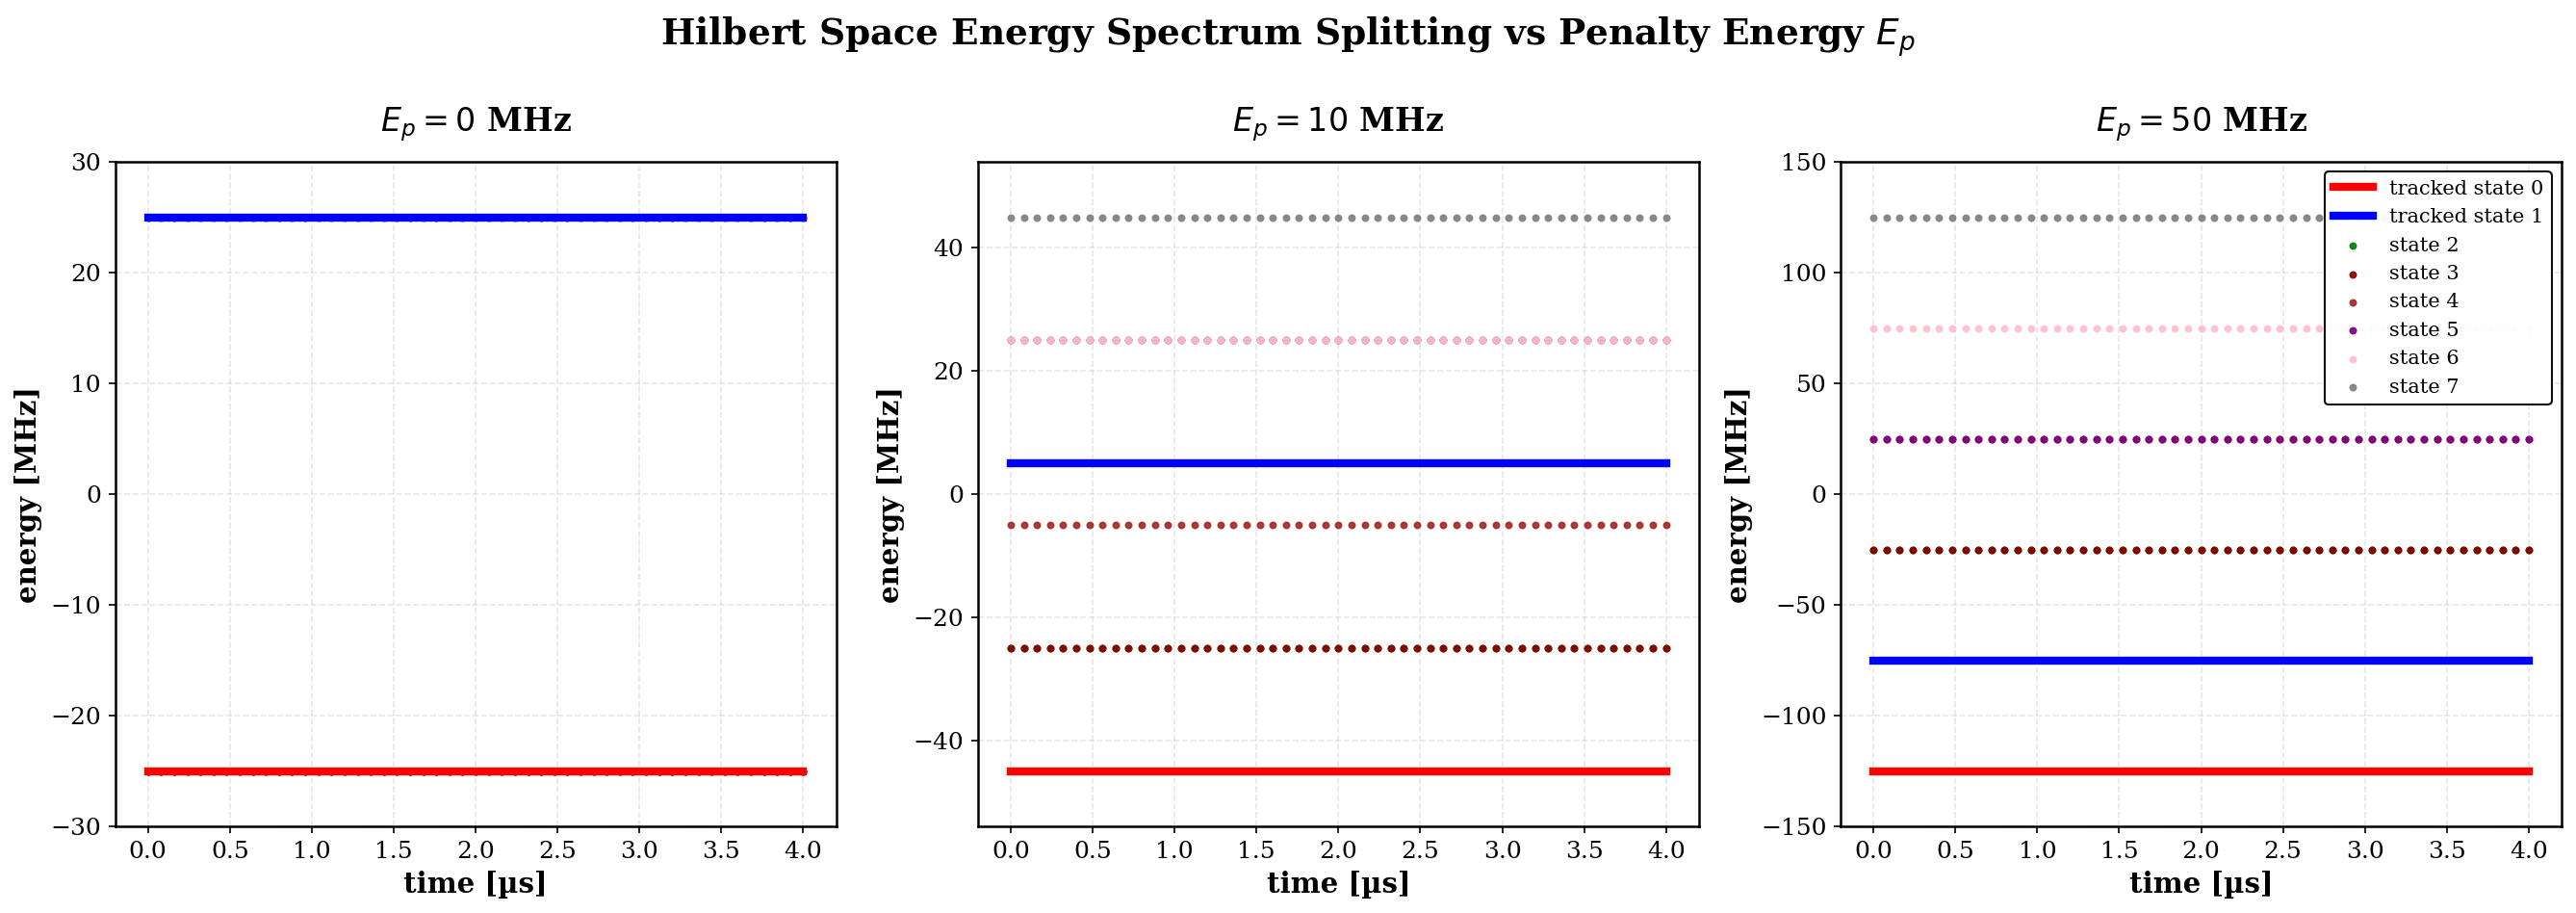


PHYSICS INTERPRETATION
• Left panel (Ep = 0 MHz):
  - No penalty → logical states can interact freely
  - Avoided crossing behavior visible
  - Minimal separation from error states

• Middle panel (Ep = 10 MHz):
  - Light penalty → moderate separation
  - Beginning of logical subspace formation
  - Error states start to separate

• Right panel (Ep = 50 MHz):
  - Strong penalty → well-separated logical subspace
  - Error states pushed to higher energies
  - Stable logical qubit encoding

Key insight: Ep controls the energy gap between logical and error sectors,
enabling robust quantum error correction through energy selectivity.


In [7]:
# ============================================================================
# THESIS-QUALITY ENERGY SPECTRUM SPLITTING FIGURE
# ============================================================================
"""
Publication-ready visualization of Hilbert space energy spectrum splitting
for different penalty energies Ep. Shows how Ep controls the separation
between logical subspace and error states.
"""

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# Set publication-quality matplotlib parameters
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 1.2

print("="*70)
print("GENERATING ENERGY SPECTRUM SPLITTING FIGURE")
print("="*70)

# Different Ep values to compare
Ep_values = [0, 10, 50]  # MHz
Ep_labels = [f"$E_p = {Ep}$ MHz" for Ep in Ep_values]

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

# Color scheme for states
colors_main = ['red', 'blue']  # Logical subspace (continuous lines)
colors_other = ['green', 'darkred', 'brown', 'purple', 'pink', 'gray']  # Other states (dashed)

print(f"Generating spectra for Ep values: {Ep_values} MHz")

def track_code_eigs_no_crossing(t_list, pc_thresh=0.1):
    """
    Track eigenvalues ensuring logical states don't cross by maintaining
    continuity based on overlap with initial logical states.
    """
    # t=0
    evals0, evecs0 = H(0).eigenstates()
    dim = len(evals0)
    energies = {i: [] for i in range(dim)}

    # Find logical states at t=0 based on overlap with |0_L> and |1_L>
    overlaps_0L = np.array([abs(logical_zero.dag() * v) for v in evecs0])
    overlaps_1L = np.array([abs(logical_one.dag() * v) for v in evecs0])
    
    # Assign logical states based on maximum overlap
    idx0L0 = np.argmax(overlaps_0L)
    idx1L0 = np.argmax(overlaps_1L)
    
    # If same state has max overlap with both, pick second best for one
    if idx0L0 == idx1L0:
        sorted_indices = np.argsort(overlaps_1L)[::-1]
        idx1L0 = sorted_indices[1]  # Second best overlap with |1_L>

    energies[0].append(float(evals0[idx0L0]))
    energies[1].append(float(evals0[idx1L0]))

    # Store initial eigenvectors for continuity tracking
    prev_evecs = evecs0.copy()
    prev_idx0L = idx0L0
    prev_idx1L = idx1L0

    # loop over times
    for t in t_list[1:]:
        evals, evecs = H(t).eigenstates()
        
        # Find states most similar to previous logical states
        overlaps_prev0 = np.array([abs(prev_evecs[prev_idx0L].dag() * v) for v in evecs])
        overlaps_prev1 = np.array([abs(prev_evecs[prev_idx1L].dag() * v) for v in evecs])
        
        # Assign based on continuity (highest overlap with previous state)
        idx0L = np.argmax(overlaps_prev0)
        idx1L = np.argmax(overlaps_prev1)
        
        # Ensure we don't assign the same state to both logical states
        if idx0L == idx1L:
            # If same state, pick the one with higher overlap
            if overlaps_prev0[idx0L] > overlaps_prev1[idx1L]:
                # Keep idx0L, find next best for idx1L
                sorted_indices = np.argsort(overlaps_prev1)[::-1]
                idx1L = sorted_indices[1]
            else:
                # Keep idx1L, find next best for idx0L
                sorted_indices = np.argsort(overlaps_prev0)[::-1]
                idx0L = sorted_indices[1]

        energies[0].append(float(evals[idx0L]))
        energies[1].append(float(evals[idx1L]))

        # Update for next iteration
        prev_evecs = evecs.copy()
        prev_idx0L = idx0L
        prev_idx1L = idx1L

        # Fill remaining states (sorted by energy)
        rest = [j for j in range(dim) if j not in (idx0L, idx1L)]
        rest = sorted(rest, key=lambda j: float(evals[j]))
        for k, j in enumerate(rest, start=2):
            energies[k].append(float(evals[j]))

    return energies

for idx, Ep_val in enumerate(Ep_values):
    ax = axes[idx]
    
    print(f"  Computing spectrum for Ep = {Ep_val} MHz...")
    
    # Set Ep for this subplot
    Ep_rad = Ep_val * 2 * np.pi * 1e6  # Convert MHz to rad/s
    
    # Create Hamiltonian with current Ep value
    def H_with_Ep(t):
        """Hamiltonian with specific Ep value"""
        return (tensor(X, X, X) * omega_t(t) + 
                tensor(Z, Z, Z) * delta_t(t) - 
                Ep_rad * (S1 + S2)).to('csr')
    
    # Temporarily replace global H function
    global H
    H_original = H
    H = H_with_Ep
    
    try:
        # Compute energy spectrum for this Ep using no-crossing tracking
        energies_ep = track_code_eigs_no_crossing(t_list, pc_thresh=0.1)
        
        # Convert time to plotting units
        t_plot = t_list * params["to_time_units"]
        
        # Collect all energies for this subplot to determine y-limits
        all_energies = []
        
        # Use the original time array length - don't trim it
        # This ensures perfect alignment between all states
        t_plot_final = t_plot
        
        # Plot logical subspace (states 0 and 1) as continuous lines
        for i in range(2):
            if i in energies_ep and len(energies_ep[i]) > 0:
                e_plot = np.array(energies_ep[i]) * params["to_freq_units"]
                # Use the same length as t_plot_final
                if len(e_plot) >= len(t_plot_final):
                    e_plot_final = e_plot[:len(t_plot_final)]
                else:
                    # Pad with the last value if needed
                    e_plot_final = np.pad(e_plot, (0, len(t_plot_final) - len(e_plot)), mode='edge')
                
                all_energies.extend(e_plot_final)
                ax.plot(t_plot_final, e_plot_final,
                       color=colors_main[i],
                       linewidth=4,
                       label=f'tracked state {i}',
                       zorder=10)
        
        # Plot other states as dense dots (appears continuous)
        # Skip states 0 and 1 to avoid overlap with logical states
        for i in range(2, min(8, len(energies_ep))):
            if i in energies_ep and len(energies_ep[i]) > 0:
                e_plot = np.array(energies_ep[i]) * params["to_freq_units"]
                # Use the same length as t_plot_final
                if len(e_plot) >= len(t_plot_final):
                    e_plot_final = e_plot[:len(t_plot_final)]
                else:
                    # Pad with the last value if needed
                    e_plot_final = np.pad(e_plot, (0, len(t_plot_final) - len(e_plot)), mode='edge')
                
                all_energies.extend(e_plot_final)
                color_idx = (i - 2) % len(colors_other)
                
                # Use dense dots to create continuous appearance
                ax.scatter(t_plot_final, e_plot_final,
                         color=colors_other[color_idx],
                         s=8,  # Small dots
                         alpha=0.9,
                         label=f'state {i}',
                         zorder=5)
        
        # Set dynamic y-limits based on actual energy range
        if all_energies:
            min_energy = min(all_energies)
            max_energy = max(all_energies)
            energy_range = max_energy - min_energy
            
            # Add 10% padding above and below
            padding = energy_range * 0.1
            y_min = min_energy - padding
            y_max = max_energy + padding
            
            ax.set_ylim(y_min, y_max)
            print(f"    Energy range: [{min_energy:.1f}, {max_energy:.1f}] MHz")
        
        # Styling for each subplot
        ax.set_xlabel(params["time_unit_label"], fontweight='bold')
        ax.set_ylabel(params["energy_unit_label"], fontweight='bold')
        ax.set_title(Ep_labels[idx], fontweight='bold', pad=15)  # Increased pad
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
        
        # Add legend only to the rightmost subplot
        if idx == 2:
            ax.legend(loc='upper right', framealpha=0.95, edgecolor='black', 
                     fancybox=True, fontsize=10)
    
    finally:
        # Restore original H function
        H = H_original

# Overall title - moved higher
fig.suptitle('Hilbert Space Energy Spectrum Splitting vs Penalty Energy $E_p$', 
             fontweight='bold', fontsize=18, y=1.05)  # Increased y from 0.98 to 1.05

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Increased from 0.9 to make more space for title

# Save high-resolution version for thesis
os.makedirs('figs', exist_ok=True)
output_path = f'figs/energy_spectrum_splitting_thesis_{PLATFORM}.png'
output_path_pdf = f'figs/energy_spectrum_splitting_thesis_{PLATFORM}.pdf'

fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
fig.savefig(output_path_pdf, bbox_inches='tight', facecolor='white')

print(f"\n✓ Thesis-quality energy spectrum figure saved:")
print(f"  → PNG: {output_path}")
print(f"  → PDF: {output_path_pdf}")

plt.show()

# ============================================================================
# PHYSICS INTERPRETATION
# ============================================================================
print("\n" + "="*70)
print("PHYSICS INTERPRETATION")
print("="*70)
print("• Left panel (Ep = 0 MHz):")
print("  - No penalty → logical states can interact freely")
print("  - Avoided crossing behavior visible")
print("  - Minimal separation from error states")
print()
print("• Middle panel (Ep = 10 MHz):")
print("  - Light penalty → moderate separation")
print("  - Beginning of logical subspace formation")
print("  - Error states start to separate")
print()
print("• Right panel (Ep = 50 MHz):")
print("  - Strong penalty → well-separated logical subspace")
print("  - Error states pushed to higher energies")
print("  - Stable logical qubit encoding")
print()
print("Key insight: Ep controls the energy gap between logical and error sectors,")
print("enabling robust quantum error correction through energy selectivity.")
print("="*70)


In [8]:
# ---------- Hamiltonians ----------
def H0(t):
    """Bare RAP logical Hamiltonian (no penalty)."""
    Ht = X_L * omega_t(t) + Z_L * delta_t(t)
    return Ht.to('csr')

def make_H_func(Ep_val):
    """Return H(t, args) including the chosen penalty."""
    S_sum = S1 + S2
    def _H(t, args=None):
        Ht = H0(t) - Ep_val * S_sum
        return Ht.to('csr')
    return _H

# ---------- Thermal factor (unit-consistent) ----------
# def bose_einstein_N(omega_pos, T_K, platform=PLATFORM):
#     if T_K <= 0 or omega_pos <= 0:
#         return 0.0
#     kBT_over_hbar_rad_per_s = (kB * T_K) / hbar      # [rad/s]
#     kBT_over_hbar = kBT_over_hbar_rad_per_s * (1e-6 if platform.lower() == "quera" else 1.0)
#     x = omega_pos / kBT_over_hbar
#     x = np.clip(x, 1e-12, 700.0)
#     return 1.0 / (np.exp(x) - 1.0)

def bose_einstein_N(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1.0 / (np.exp(energy_diff*hbar / (kB * temperature)) - 1)


def spectral_amp(omega_pos, lambda_2):
    return 0.0 if omega_pos <= 0 else np.sqrt(lambda_2)


def spectral_amp(omega_pos, lambda_2, platform=PLATFORM, model='ibm',
                 omega_c=None, omega_ref=None, s=1.0):
    """
    Returns sqrt( |g_ba|^2 ) = sqrt( lambda_2 * f(omega_pos) ).
    - If model='flat' : f(ω)=1 (your current assumption).
    - If model='ohmic': f(ω)=(ω/ω_ref)^s * exp(-ω/ω_c)  [default s=1].
    Units:
      - ibm: ω in rad/s, omega_c in rad/s
      - quera: ω in rad/µs, omega_c in rad/µs
    """
    if omega_pos <= 0:
        return 0.0
    p = platform.lower().strip()
    if model is None:
        # neutral atoms: flat is a reasonable effective model; transmons: ohmic is common
        model = 'flat' if p == 'quera' else 'ohmic'

    # sensible references if user doesn't pass them
    if omega_ref is None:
        omega_ref = max(1e-12, float(params.get('omega_max', omega_pos)))
    if omega_c is None:
        omega_c = (2*np.pi*2e8) if p == 'ibm' else 50.0   # ~200 MHz cutoff (IBM) or ~50 rad/µs (QuEra)

    if model == 'flat':
        f = 1.0
    elif model == 'ohmic':
        f = (omega_pos/omega_ref)**float(s) * np.exp(-omega_pos/omega_c)
    else:
        f = 1.0  # fallback to flat

    return np.sqrt(lambda_2 * f)

# ---------- Collapse-operator generator ----------
def c_ops_gen_thermal(t_eval, H_func, n_qubits, lambda_2, T_K):
    Ht = H_func(t_eval, None)
    evals, evecs = Ht.eigenstates()
    dim = len(evals)

    c_ops = []
    for b in range(2, dim):
        omega = float(evals[b] - evals[0])  # >0
        if abs(omega) < 1e-8:
            continue

        rate_abs = 0.0  # 0 -> b
        rate_em  = 0.0  # b -> 0
        for i in range(n_qubits):
            sigmam_i = tensor([sigmam() if j == i else I for j in range(n_qubits)])
            # complex scalar matrix element <b|sigmam_i|0>
            m_ba = (evecs[b].dag() * sigmam_i * evecs[0])
            mag2 = float(np.abs(m_ba)**2)
            if mag2 < 1e-8:
                continue

            g = spectral_amp(omega, lambda_2)
            N = bose_einstein_N(omega, T_K)
            rate_abs += N       * (g**2) * mag2
            rate_em  += (N + 1) * (g**2) * mag2

        if rate_abs > 1e-8:
            Lop = (evecs[b] * evecs[0].dag()).to('csr')      # |b><0|
            c_ops.append(np.sqrt(rate_abs) * Lop)
        if rate_em > 1e-8:
            Lop = (evecs[0] * evecs[b].dag()).to('csr')      # |0><b|
            c_ops.append(np.sqrt(rate_em) * Lop)
    return c_ops

In [9]:
# ---------- Simulation setup ----------
n_qubits = 3
initial_state = logical_zero

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one  * logical_one.dag()
e_ops = [rho0, rho1]

# Ideal (unitary) benchmark with Ep=0
H_ideal = make_H_func(Ep_val=0.0)
res_ideal = sesolve(H_ideal, initial_state, t_list, e_ops=e_ops)
ideal_fidelity = res_ideal.expect[1]   # <1_L|rho|1_L>


T_K        = params["T_phys_K"]

def _last_state(result):
    """Robustly fetch last state from a QuTiP result."""
    if hasattr(result, "states") and result.states:
        return result.states[-1]
    if hasattr(result, "state") and (result.state is not None):
        return result.state
    raise RuntimeError("Solver returned no states. Enable store_states=True.")

fidelity_curves = []
for Ep_val in Ep_vec:
    print(f"Ep = {Ep_val}")
    H_fun = make_H_func(Ep_val)

    rho = initial_state * initial_state.dag()
    f_track = [float((rho1*rho).tr().real)]  # include t0

    for k in range(1, len(t_list)):
        t0, t1  = t_list[k-1], t_list[k]
        t_mid   = 0.5*(t0 + t1)
        c_ops   = c_ops_gen_thermal(t_mid, H_fun, n_qubits=n_qubits,
                                    lambda_2=lambda_2, T_K=T_K)
        opts = Options(store_states=True)
        result = mesolve(H_fun, rho, [t0, t1], c_ops=c_ops,
                         e_ops=e_ops, args=None, options=opts)

        rho = _last_state(result)
        f_track.append(result.expect[1][-1])

    fidelity_curves.append(np.array(f_track))

# ---------- Plot ----------
fig = go.Figure()
fig.add_trace(go.Scatter(x=t_list*params["to_time_units"], y=ideal_fidelity,
                         mode='lines', line=dict(dash='dash', width=3), name='Ideal (unitary)'))

for i, Ep_val in enumerate(Ep_vec):
    fig.add_trace(go.Scatter(x=t_list*params["to_time_units"], y=fidelity_curves[i],
                             mode='lines', name=f"Ep={Ep_val*params['to_freq_units']:.1f} MHz",))
fig.update_layout(
    title=f'Protocol fidelity vs time — {PLATFORM.upper()} units',
    xaxis_title=params["time_unit_label"],
    yaxis_title='Fidelity to |1_L⟩',
    template='plotly_white'
)
fig.show()

print("Done: Fidelity curves plotted.")


Ep = 62831853.071795866


/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.



Ep = 125663706.14359173
Ep = 314159265.3589793
Ep = 628318530.7179586
Ep = 1256637061.4359171


KeyboardInterrupt: 

In [ ]:
# =========================
# JFS instantaneous bound vs Ep (MHz) — single cell
# =========================
# ---- helpers (robust scalar & codespace test) ----
def _scalar(x):
    try:
        return complex(x.full()[0,0])    # 1x1 Qobj
    except AttributeError:
        return complex(x)                # already a complex

def in_codespace(psi, tol=1e-6):
    s1 = float(np.real(_scalar(psi.dag()*S1*psi)))
    s2 = float(np.real(_scalar(psi.dag()*S2*psi)))
    return (abs(s1-1.0) < tol) and (abs(s2-1.0) < tol)

# ---- C(t): prefactor without Bose factor (spectral + matrix elements only) ----
def C_out_prefactor_at_t(t, H_func, n_qubits=3, lambda_2=lambda_2):
    Ht = H_func(t)
    evals, evecs = Ht.eigenstates()
    a = evecs[0]; Ea = float(evals[0])

    sm_ops = [tensor([sigmam() if j==i else qeye(2) for j in range(n_qubits)]) for i in range(n_qubits)]
    total = 0.0
    for b_idx in range(1, len(evals)):
        b = evecs[b_idx]
        if in_codespace(b):                 # only C^⊥
            continue
        Eb = float(evals[b_idx])
        omega = Eb - Ea
        if omega <= 1e-12:
            continue
        g_amp = spectral_amp(omega, lambda_2, platform=PLATFORM, model=None)
        if g_amp == 0.0:
            continue
        acc = 0.0
        for sm in sm_ops:
            m = _scalar(a.dag()*sm*b)       # <0|σ^-|b>
            acc += float(np.abs(m)**2)
        total += (g_amp**2) * acc
    return float(total)

# ---- use MAX over time for instantaneous condition ----
def C_max_for_Ep(Ep_val):
    H_fun = make_H_func(Ep_val)
    C_vals = [C_out_prefactor_at_t(t, H_fun, n_qubits=3, lambda_2=lambda_2) for t in t_list]
    return float(np.nanmax(C_vals)) if len(C_vals) else 0.0

# ---- Ep to MHz (x-axis) ----
def Ep_to_MHz(Ep_val):
    # IBM: Ep [rad/s] -> MHz ; QuEra: Ep [rad/µs] -> MHz
    return (Ep_val/(2*np.pi)) / (1e6 if PLATFORM.lower()=="ibm" else 1.0)

# ---- Build instantaneous bound curve vs Ep (MHz) ----
Ep_MHz_axis = []
Smax_bound  = []    # [1/time] = N(Ep) * max_t C(t)

for Ep_val in Ep_vec:
    Cmax = C_max_for_Ep(Ep_val)                                    # max_t C(t)
    N_Ep = bose_einstein_N(Ep_val, T_phys_K)    # Bose at ω = Ep
    Smax_bound.append(N_Ep * Cmax)
    Ep_MHz_axis.append(Ep_to_MHz(Ep_val))

Ep_MHz_axis = np.asarray(Ep_MHz_axis, dtype=float)
Smax_bound  = np.asarray(Smax_bound,  dtype=float)

# ---- Physics-based threshold: ε_R · Ω_max (timescale separation) ----
Omega_max   = omega_max                 # angular coherent scale (rad/s or rad/µs)
epsilon_R   = 1e-2                      # 1% tolerance (adjust if desired)
S_threshold = epsilon_R * Omega_max     # [1/time]

# Find first crossing correctly (avoid NumPy truth-value pitfalls)
mask = Smax_bound <= S_threshold
idx_R = int(np.where(mask)[0][0]) if np.any(mask) else None

# ---- Plot (only instantaneous figure) ----
rate_unit = ('1/s' if PLATFORM.lower()=='ibm' else '1/µs')
ymax = (np.nanmax(Smax_bound) if np.isfinite(Smax_bound).any() else 1.0) * 1.05


fig = go.Figure()

# main curve (note: using your prior conversion factor for consistency with earlier cells)
fig.add_trace(go.Scatter(
    x=Ep_MHz_axis,
    y=Smax_bound * params['to_freq_units'],
    mode='lines+markers',
    name='N(Ep) · max_t C(t)  (upper bound on max_t S_out)'
))

# horizontal threshold line
fig.add_hline(
    y=S_threshold * params['to_freq_units'],
    line=dict(color='green', dash='dash'),
    annotation_text=f"ε_R·Ω_max = {S_threshold*params['to_freq_units']:.3g} [{rate_unit}] (ε_R={epsilon_R:g})",
    annotation_position="top left"
)

# shaded region below the threshold (whole x-range)
x0, x1 = float(np.nanmin(Ep_MHz_axis)), float(np.nanmax(Ep_MHz_axis))
fig.add_shape(
    type="rect",
    x0=x0, x1=x1,
    y0=0, y1=S_threshold * params['to_freq_units'],
    fillcolor="rgba(0, 200, 0, 0.12)",
    line_width=0,
    layer="below"
)

fig.update_layout(
    title=f"Instantaneous leakage bound vs Ep  — {PLATFORM.upper()}, T={T_phys_K} K",
    xaxis_title="Penalty Ep [MHz]",
    yaxis_title=f"N(Ep) · max_t C(t)  [{rate_unit}]",
    template="plotly_white",
    yaxis=dict(range=[0, ymax * params['to_freq_units']])
)
fig.show()

# (Optional) you can still print the smallest Ep that falls under the threshold if you want a numeric statement:
mask = (Smax_bound <= S_threshold)
if np.any(mask):
    first_idx = int(np.where(mask)[0][0])
    print(f"First Ep under threshold (instantaneous): ~{Ep_MHz_axis[first_idx]:.3g} MHz")


First Ep under threshold (instantaneous): ~20 MHz


In [ ]:
# --- c_ops_gen_new_with_tracking (robust scalar coefficients per transition) ---

def c_ops_gen_new_with_tracking(t, args):
    """Compute scalar c-coefficients for transitions at time t.

    Returns a dict mapping (a_idx, b_idx) -> [c_coef_scalar, ...] for the instant t.
    The implementation sums rates across single-qubit operators and then takes
    the square root to produce the scalar collapse amplitude, matching the
    convention used in `c_ops_gen_thermal`.
    """
    H_inst_t = args['args_H'](t)
    eigenvalues, eigenstates = H_inst_t.eigenstates()
    c_coef_tracking = {}

    # reference state index and its eigenvalue/vector
    a_idx = 0
    omega_a = float(eigenvalues[a_idx])
    a_state = eigenstates[a_idx]

    for b_offset, b_state in enumerate(eigenstates[1:]):
        b_i = 1 + b_offset
        omega_b = float(eigenvalues[b_i])

        # skip nearly-degenerate pairs
        if np.abs(omega_a - omega_b) < 1e-12:
            continue

        # accumulate total rates for this transition
        rate_total = 0.0

        for i_qubit in range(args['n_qubits']):
            sigmam_i = tensor([sigmam() if j == i_qubit else qeye(2) for j in range(args['n_qubits'])])

            # compute matrix element <b| sigmam_i |a>
            m_obj = b_state.dag() * sigmam_i * a_state
            mag2 = float(np.abs(m_obj) ** 2)
            if mag2 < 1e-8:
                continue

            # spectral and thermal factors (use positive frequency)
            freq = abs(omega_b - omega_a)
            g = spectral_amp(freq, args.get('lambda_2', 0.0))
            N = bose_einstein_N(freq, args.get('T', 0.0))

            rate_abs = N       * (g**2) * mag2
            rate_em  = (N + 1) * (g**2) * mag2
            rate_total += rate_abs + rate_em

        # produce scalar coefficient = sqrt(total_rate)
        c_scalar = float(np.sqrt(max(0.0, rate_total)))

        transition_key = (a_idx, b_i)
        c_coef_tracking.setdefault(transition_key, []).append(c_scalar)

    return c_coef_tracking

# --- End function ---

In [ ]:
# --- Collect c-coefs over t_list and plot per-transition (only transitions from state 0) ---
# Define args for tracking (example Ep and parameters)
Ep = params.get('Ep', 0.0)

args_tracking = {
    'args_H': lambda t: make_H_func(Ep)(t),
    'n_qubits': n_qubits,
    'lambda_2': lambda_2,
    'T': T_K
}

c_coef_tracking_all = {}
for t in t_list:
    cct = c_ops_gen_new_with_tracking(t, args_tracking)
    for key, vals in cct.items():
        # consider only transitions that originate from state 0 (i.e., key[0] == 0)
        try:
            a_idx = key[0]
        except Exception:
            # if key isn't indexable, skip
            continue


        # convert to real scalars (abs) and append
        scalars = [float(np.abs(v)) for v in vals]
        c_coef_tracking_all.setdefault(key, []).append(np.mean(scalars) if scalars else 0.0)

if not c_coef_tracking_all:
    print('Warning: no transitions from state 0 were found in the tracking results.')

# Build plot
fig = go.Figure()
for key, series in sorted(c_coef_tracking_all.items()):
    fig.add_trace(go.Scatter(x=t_list*params['to_time_units'], y=series,
                             mode='lines+markers', name=f"{key}"))
fig.update_layout(title='Tracked c-coefficients for transitions from state 0',
                  xaxis_title=params['time_unit_label'], yaxis_title='c_coef (mean abs)', template='plotly_white')
fig.show()

print('Done: c-coef tracking (from state 0) plotted.')

Done: c-coef tracking (from state 0) plotted.


In [ ]:
# --- Reduced-grid Ep/T sweep (platform-correct β→Ep mapping, labeled plots) ---

# Use platform temperatures (Kelvin) and beta_vec (dimensionless Ep/(kB T))
T_vec   = temperatures.copy()
beta_ls = beta_vec.copy()

# sample ~10 times from t_list for speed
max_samples = 10
step = max(1, len(t_list) // max_samples)
sampled_t_list = t_list[::step]
if sampled_t_list[-1] != t_list[-1]:
    sampled_t_list = np.concatenate((sampled_t_list, [t_list[-1]]))

# Helper: kB T / ħ in simulator angular units
def kBT_over_hbar_platform(T_K):
    # base: rad/s
    val = (kB * float(T_K)) / hbar
    # convert to rad/µs for QuEra
    return val * (1e-6 if PLATFORM.lower() == "quera" else 1.0)

# Helper: Ep (angular) -> MHz for readability
def Ep_to_MHz(Ep_val):
    return (Ep_val/(2*np.pi)) / (1e6 if PLATFORM.lower() == "ibm" else 1.0)

results_by_beta = {}

for beta in beta_ls:
    sums_per_T = []
    fid_per_T  = []
    Ep_per_T   = []
    EpMHz_per_T= []

    for T in tqdm(T_vec, desc=f"β={beta}", leave=False):
        # ---- physics-correct mapping β → Ep ----
        Ep = beta * kBT_over_hbar_platform(T)     # angular units of the simulator
        Ep_per_T.append(Ep)
        EpMHz_per_T.append(Ep_to_MHz(Ep))

        # build H(t) with this Ep
        H_fun = make_H_func(Ep)

        # args for tracking helper (assumes c_ops_gen_new_with_tracking uses bose_einstein_N with Kelvin)
        args_loc = {
            'args_H': lambda tt, H_fun=H_fun: H_fun(tt),
            'n_qubits': n_qubits,
            'lambda_2': lambda_2,
            'T': float(T)  # Kelvin, consistent with bose_einstein_N
        }

        # 1) accumulate a proxy: sum of |c_coef| over sampled times (dimension: sqrt(rate))
        sum_coefs = 0.0
        try:
            for tt in sampled_t_list:
                cct = c_ops_gen_new_with_tracking(tt, args_loc)
                if isinstance(cct, dict):
                    for key, vals in cct.items():
                        # only transitions starting from ground index 0 (optional filter)
                        try:
                            if key[0] != 0:
                                continue
                        except Exception:
                            pass
                        if isinstance(vals, (list, tuple, np.ndarray)):
                            sum_coefs += float(np.nansum(np.abs(np.asarray(vals, dtype=float))))
                        else:
                            try:
                                sum_coefs += float(abs(vals))
                            except Exception:
                                pass
                elif isinstance(cct, (list, tuple, np.ndarray)):
                    sum_coefs += float(np.nansum(np.abs(np.asarray(cct, dtype=float))))
        except Exception:
            sum_coefs = np.nan

        sums_per_T.append(sum_coefs)

        # 2) piecewise open-system propagation on sampled grid
        rho = logical_zero * logical_zero.dag()
        prev_time = float(sampled_t_list[0])
        final_fid = np.nan
        try:
            for dt in sampled_t_list[1:]:
                t_mid = 0.5 * (prev_time + float(dt))
                try:
                    c_ops_segment = c_ops_gen_thermal(t_mid, H_fun, n_qubits, lambda_2, float(T))
                except Exception:
                    c_ops_segment = None

                t_steps = [prev_time, float(dt)]
                opts = Options(store_states=True, nsteps=10000, rtol=1e-7, atol=1e-9)
                try:
                    res = mesolve(H_fun, rho, t_steps, c_ops=c_ops_segment, args=None,
                                  e_ops=[logical_zero*logical_zero.dag(), logical_one*logical_one.dag()],
                                  options=opts)
                except Exception:
                    # fallback (unitary segment)
                    res = mesolve(H_fun, rho, t_steps, c_ops=None, args=None,
                                  e_ops=[logical_zero*logical_zero.dag(), logical_one*logical_one.dag()],
                                  options=opts)

                prev_time = float(dt)
                rho = res.states[-1]

            final_fid = float((rho1 * rho).tr().real)
        except Exception:
            final_fid = np.nan

        fid_per_T.append(final_fid)

    results_by_beta[beta] = {
        "T": np.array(T_vec, dtype=float),
        "Ep": np.array(Ep_per_T, dtype=float),
        "Ep_MHz": np.array(EpMHz_per_T, dtype=float),
        "sum_coefs": np.array(sums_per_T, dtype=float),
        "fid": np.array(fid_per_T, dtype=float),
    }

# ---- Plot: final fidelity vs summed collapse-coefs (one curve per β), platform-aware labels ----
fig1 = go.Figure()
for beta, data in results_by_beta.items():
    x = data["sum_coefs"]
    y = data["fid"]
    valid = np.isfinite(x) & np.isfinite(y)
    if np.any(valid):
        order = np.argsort(x[valid])
        fig1.add_trace(go.Scatter(
            x=x[valid][order], y=y[valid][order],
            mode='lines+markers',
            name=f"β = Ep/(kB T) = {beta:g}"
        ))
fig1.update_xaxes(title_text='∑ |c_coef| over sampled times (proxy; sqrt(rate)), log scale', type='log')
fig1.update_yaxes(title_text='Final fidelity to |1_L|')
fig1.update_layout(
    title=f'Final fidelity vs summed collapse-coefs (curves = Ep/T families) — {PLATFORM.upper()}',
    template='simple_white'
)
fig1.show()

# ---- Optional: quick table so you see Ep values in MHz for each (β, T) ----
for beta, data in results_by_beta.items():
    print(f"\nβ = {beta}:")
    for T, Ep_val, EpMHz, s, f in zip(data["T"], data["Ep"], data["Ep_MHz"], data["sum_coefs"], data["fid"]):
        unit = "rad/s" if PLATFORM.lower()=="ibm" else "rad/µs"
        print(f"  T={T:.3g} K | Ep={Ep_val:.3e} {unit} (~{EpMHz:.3g} MHz) | sum_coef={s:.3e} | fid={f if np.isfinite(f) else 'nan'}")

# Expose for later
globals()['results_by_beta'] = results_by_beta
print('\nDone: reduced-grid Ep/T sweep complete with platform-correct β→Ep mapping.')


β=0.1:   0%|          | 0/8 [00:00<?, ?it/s]/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.




β = 0.1:
  T=0.008 K | Ep=1.047e+08 rad/s (~16.7 MHz) | sum_coef=5.882e+03 | fid=0.9118810974923293
  T=0.01 K | Ep=1.309e+08 rad/s (~20.8 MHz) | sum_coef=6.063e+03 | fid=0.903136413542643
  T=0.012 K | Ep=1.571e+08 rad/s (~25 MHz) | sum_coef=6.206e+03 | fid=0.8764526782074482
  T=0.015 K | Ep=1.964e+08 rad/s (~31.3 MHz) | sum_coef=6.370e+03 | fid=0.8681116108827129
  T=0.02 K | Ep=2.618e+08 rad/s (~41.7 MHz) | sum_coef=6.563e+03 | fid=0.8579562471753813
  T=0.03 K | Ep=3.928e+08 rad/s (~62.5 MHz) | sum_coef=6.793e+03 | fid=0.8453156810338264
  T=0.05 K | Ep=6.546e+08 rad/s (~104 MHz) | sum_coef=7.014e+03 | fid=0.8327231573309759
  T=0.1 K | Ep=1.309e+09 rad/s (~208 MHz) | sum_coef=7.208e+03 | fid=0.8213062644299048

β = 0.2:
  T=0.008 K | Ep=2.095e+08 rad/s (~33.3 MHz) | sum_coef=4.607e+03 | fid=0.9411369643727181
  T=0.01 K | Ep=2.618e+08 rad/s (~41.7 MHz) | sum_coef=4.706e+03 | fid=0.9369343245238408
  T=0.012 K | Ep=3.142e+08 rad/s (~50 MHz) | sum_coef=4.780e+03 | fid=0.9336944499

In [ ]:
# --- Temperature x Ep sweep (converted snippet) ---
# Uses existing helpers in this notebook: make_H_func, c_ops_gen_thermal, mesolve, initial_state, logical_one, rho1, t_list, e_ops, opts


final_fidelities = {T: [] for T in temperatures}


for T in tqdm(temperatures, desc="Processing temperatures"):
    for Ep in Ep_vec:
        # Build H(t) for this Ep
        H_fun = make_H_func(Ep)  # callable H(t)

        # Initialize state for this run
        rho = initial_state * initial_state.dag()
        prev_time = float(t_list[0])

        # Propagate piecewise across the t_list using collapse operators evaluated at segment midpoints
        for t_next in t_list[1:]:
            t_mid = 0.5 * (prev_time + float(t_next))
            # Compute thermal collapse operators (list of Qobj) at segment midpoint
            try:
                c_ops = c_ops_gen_thermal(t_mid, H_fun, n_qubits, lambda_2, T)
            except Exception:
                c_ops = None

            t_steps = [prev_time, float(t_next)]
            try:
                res = mesolve(H_fun, rho, t_steps, c_ops=c_ops, args=None, e_ops=e_ops, options={'store_states': True})
            except Exception as exc:
                # On solver failure try without collapse operators

                # DEBUG
                print(exc, Ep)
                try:
                    res = mesolve(H_fun, rho, t_steps, c_ops=None, args=None, e_ops=e_ops)
                except Exception:
                    raise RuntimeError(f"mesolve failed for Ep={Ep}, T={T}, segment {prev_time}->{t_next}: {exc}")

            # Advance
            rho = res.states[-1]
            prev_time = float(t_next)

        # final fidelity to logical one
        final_fid = float((rho1 * rho).tr().real)
        final_fidelities[T].append(final_fid)

# Plot results
fig = go.Figure()
for T, fidelities in final_fidelities.items():
    fig.add_trace(go.Scatter(x=[i*params["to_freq_units"] for i in Ep_vec], y=fidelities, mode='lines+markers', name=f"T = {T} K"))

fig.update_layout(
    title="Final Fidelity of |1_L> vs Ep",
    xaxis_title="Energy gap parameter (same units as Ep)",
    yaxis_title="Final Fidelity to |1_L>",
    template='plotly_white'
)
fig.show()

# expose results
globals()['final_fidelities_sweep'] = final_fidelities
print('Done: temperature x Ep sweep complete. Results in final_fidelities_sweep')

Processing temperatures: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


Done: temperature x Ep sweep complete. Results in final_fidelities_sweep


In [ ]:
# --- Find minimum Ep from Ep_vec (notebook) that yields final fidelity >= 0.95 for each temperature ---

# Use notebook-provided grids if available
Ep_values = 2*np.pi*np.linspace(10000, 500000000, 51)
T_values = np.linspace(0.001, 0.1, 21)

required_Ep_for_95 = []

# Ensure logical states exist
if 'logical_zero' not in globals() or 'logical_one' not in globals():
    raise RuntimeError('logical_zero / logical_one not found in the notebook namespace')

# Main sweep: loop over temperatures and Ep_values (Ep_values assumed to be in same units used by make_H_func)
for T in tqdm(T_values, desc='Temperatures'):
    found = False
    last_final_fid = np.nan
    for Ep in tqdm(Ep_values, desc=f'Ep (T={T:.2f})', leave=False):
        H_fun = make_H_func(Ep)

        # initial state for this run
        rho = logical_zero * logical_zero.dag()
        prev_time = float(t_list[0])
        final_res = None
        for t_next in t_list[1:]:
            t_mid = 0.5 * (prev_time + float(t_next))

            # compute thermal collapse operators at midpoint using existing generator
            c_ops_segment = c_ops_gen_thermal(t_mid, H_fun, globals().get('n_qubits', 3), globals().get('lambda_2', 0.1), T)

            t_steps = [prev_time, float(t_next)]
            opts = Options(store_states=True)
            res = mesolve(H_fun, rho, t_steps, c_ops=c_ops_segment, args=None, e_ops=e_ops, options=opts)

            prev_time = float(t_next)
            rho = res.states[-1]
            final_res = res

            if final_res is None:
                final_fidelity = np.nan
            else:
                final_fidelity = float(final_res.expect[1][-1])
            last_final_fid = final_fidelity


        if not np.isnan(last_final_fid) and last_final_fid >= 0.95:
            required_Ep_for_95.append((T, Ep, last_final_fid))
            found = True
            break

    if not found:
        required_Ep_for_95.append((T, None, last_final_fid))

# Unpack and expose results
required_T = [x[0] for x in required_Ep_for_95]
required_Ep = [x[1] for x in required_Ep_for_95]
required_fid = [x[2] for x in required_Ep_for_95]
globals()['required_Ep_for_95'] = required_Ep_for_95
globals()['required_T'] = required_T
globals()['required_Ep'] = required_Ep
globals()['required_fid'] = required_fid

# Print summary
for T, Ep, fid in required_Ep_for_95:
    print(f'T={T:.2f}, required Ep={Ep}, final fidelity={fid if not np.isnan(fid) else "nan"}')

print('Done: required-Ep sweep complete. Results saved to notebook globals: required_Ep_for_95')

Temperatures:   0%|          | 0/21 [00:00<?, ?it/s]/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.

Temperatures:  33%|███▎      | 7/21 [00:33<01:32,  6.64s/it]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Temperatures:  33%|███▎      | 7/21 [00:37<01:15,  5.41s/it]


KeyboardInterrupt: 

In [ ]:
# --- Plot required Ep vs T and vs n_th ---
# Verify required results exist
if 'required_T' not in globals() or 'required_Ep' not in globals() or 'required_fid' not in globals():
    raise RuntimeError('required_T/required_Ep/required_fid not found. Run the sweep cell first.')

T = np.array(required_T, dtype=float)
Ep = np.array([np.nan if v is None else v for v in required_Ep], dtype=float)
fid = np.array(required_fid, dtype=float)

if np.all(np.isnan(Ep)):
    print('No Ep found for the fidelity target in the sweep (all values None).')
else:
    # Plot 1: Ep vs Temperature (color = final fidelity)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=T, y=Ep*params["to_freq_units"],  # convert Ep to MHz if needed
        mode='lines+markers',
        line=dict(shape='linear')
    ))
    fig.update_layout(
        title='Required $E_p$ for final fidelity ≥ 0.95 vs Temperature',
        xaxis_title='Temperature T',
        yaxis_title='Required $E_p$',
        template='simple_white',
    )
    fig.show()

GENERATING ENERGY SPECTRUM SPLITTING FIGURE
Generating spectra for Ep values: [0, 10, 50] MHz
  Computing spectrum for Ep = 0 MHz...


NameError: name 'H' is not defined

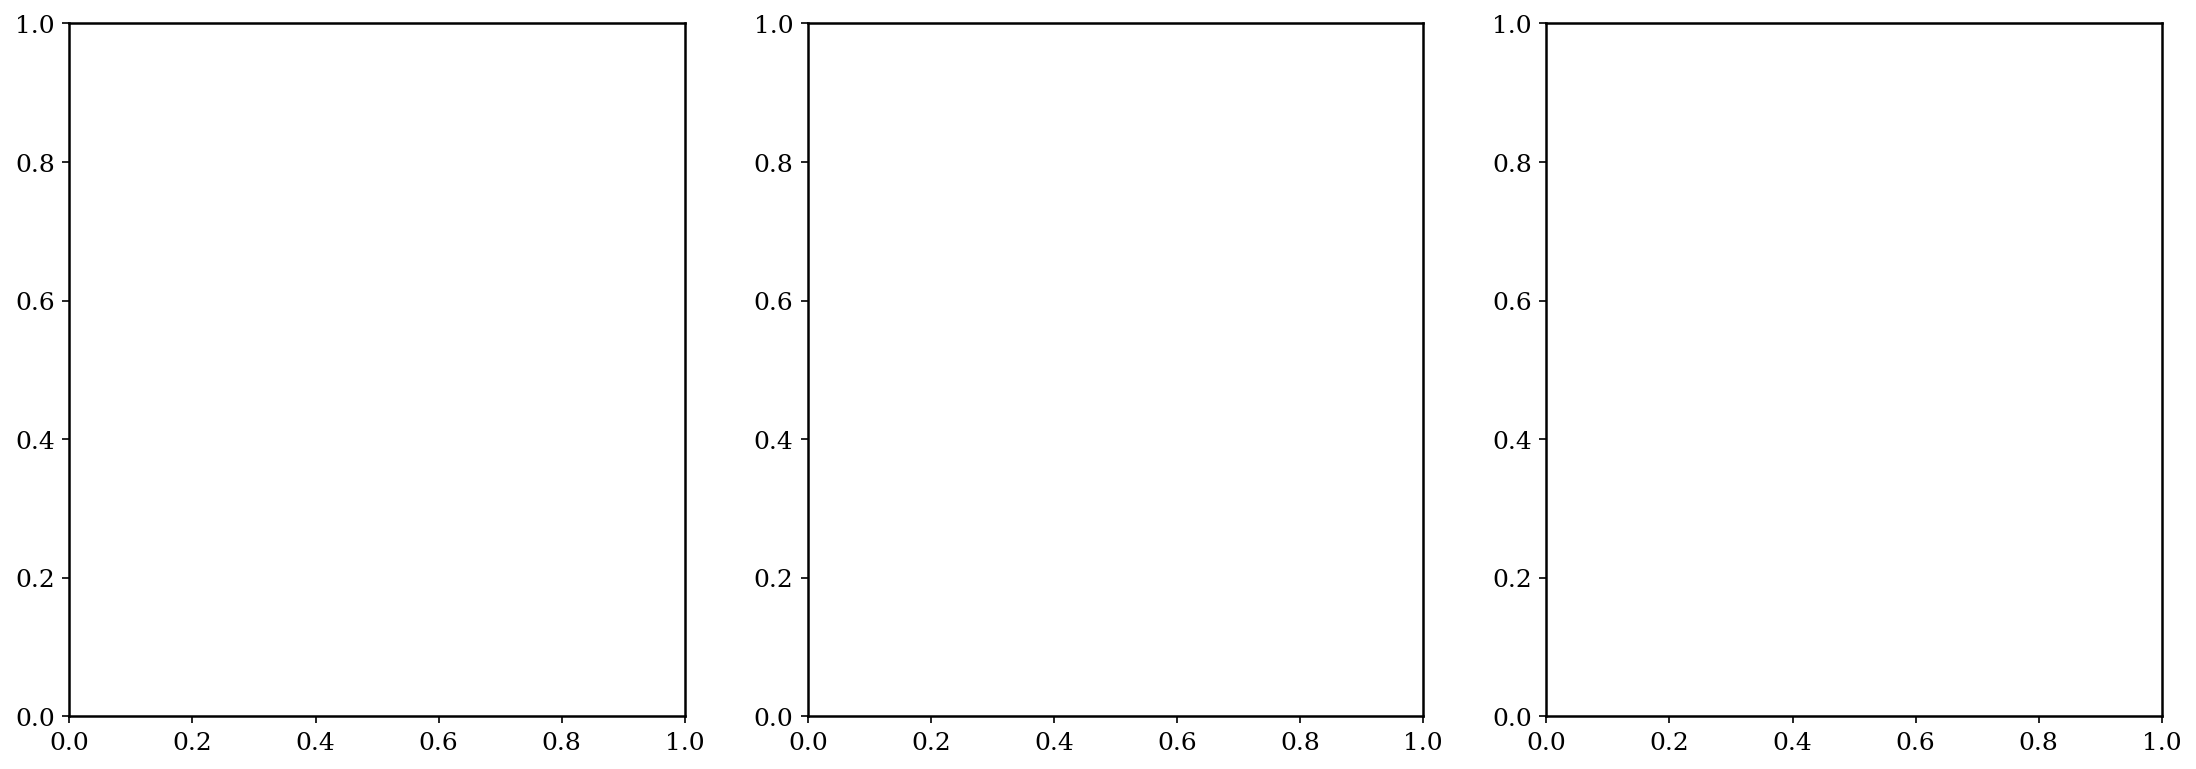

In [ ]:
# ============================================================================
# THESIS-QUALITY ENERGY SPECTRUM SPLITTING FIGURE
# ============================================================================
"""
Publication-ready visualization of Hilbert space energy spectrum splitting
for different penalty energies Ep. Shows how Ep controls the separation
between logical subspace and error states.
"""

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# Set publication-quality matplotlib parameters
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 1.2

print("="*70)
print("GENERATING ENERGY SPECTRUM SPLITTING FIGURE")
print("="*70)

# Different Ep values to compare
Ep_values = [0, 10, 50]  # MHz
Ep_labels = [f"$E_p = {Ep}$ MHz" for Ep in Ep_values]

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

# Color scheme for states
colors_main = ['red', 'blue']  # Logical subspace (continuous lines)
colors_other = ['green', 'darkred', 'brown', 'purple', 'pink', 'gray']  # Other states (dashed)

print(f"Generating spectra for Ep values: {Ep_values} MHz")

def track_code_eigs_no_crossing(t_list, pc_thresh=0.1):
    """
    Track eigenvalues ensuring logical states don't cross by maintaining
    continuity based on overlap with initial logical states.
    """
    # t=0
    evals0, evecs0 = H(0).eigenstates()
    dim = len(evals0)
    energies = {i: [] for i in range(dim)}

    # Find logical states at t=0 based on overlap with |0_L> and |1_L>
    overlaps_0L = np.array([abs(logical_zero.dag() * v) for v in evecs0])
    overlaps_1L = np.array([abs(logical_one.dag() * v) for v in evecs0])
    
    # Assign logical states based on maximum overlap
    idx0L0 = np.argmax(overlaps_0L)
    idx1L0 = np.argmax(overlaps_1L)
    
    # If same state has max overlap with both, pick second best for one
    if idx0L0 == idx1L0:
        sorted_indices = np.argsort(overlaps_1L)[::-1]
        idx1L0 = sorted_indices[1]  # Second best overlap with |1_L>

    energies[0].append(float(evals0[idx0L0]))
    energies[1].append(float(evals0[idx1L0]))

    # Store initial eigenvectors for continuity tracking
    prev_evecs = evecs0.copy()
    prev_idx0L = idx0L0
    prev_idx1L = idx1L0

    # loop over times
    for t in t_list[1:]:
        evals, evecs = H(t).eigenstates()
        
        # Find states most similar to previous logical states
        overlaps_prev0 = np.array([abs(prev_evecs[prev_idx0L].dag() * v) for v in evecs])
        overlaps_prev1 = np.array([abs(prev_evecs[prev_idx1L].dag() * v) for v in evecs])
        
        # Assign based on continuity (highest overlap with previous state)
        idx0L = np.argmax(overlaps_prev0)
        idx1L = np.argmax(overlaps_prev1)
        
        # Ensure we don't assign the same state to both logical states
        if idx0L == idx1L:
            # If same state, pick the one with higher overlap
            if overlaps_prev0[idx0L] > overlaps_prev1[idx1L]:
                # Keep idx0L, find next best for idx1L
                sorted_indices = np.argsort(overlaps_prev1)[::-1]
                idx1L = sorted_indices[1]
            else:
                # Keep idx1L, find next best for idx0L
                sorted_indices = np.argsort(overlaps_prev0)[::-1]
                idx0L = sorted_indices[1]

        energies[0].append(float(evals[idx0L]))
        energies[1].append(float(evals[idx1L]))

        # Update for next iteration
        prev_evecs = evecs.copy()
        prev_idx0L = idx0L
        prev_idx1L = idx1L

        # Fill remaining states (sorted by energy)
        rest = [j for j in range(dim) if j not in (idx0L, idx1L)]
        rest = sorted(rest, key=lambda j: float(evals[j]))
        for k, j in enumerate(rest, start=2):
            energies[k].append(float(evals[j]))

    return energies

for idx, Ep_val in enumerate(Ep_values):
    ax = axes[idx]
    
    print(f"  Computing spectrum for Ep = {Ep_val} MHz...")
    
    # Set Ep for this subplot
    Ep_rad = Ep_val * 2 * np.pi * 1e6  # Convert MHz to rad/s
    
    # Create Hamiltonian with current Ep value
    def H_with_Ep(t):
        """Hamiltonian with specific Ep value"""
        return (tensor(X, X, X) * omega_t(t) + 
                tensor(Z, Z, Z) * delta_t(t) - 
                Ep_rad * (S1 + S2)).to('csr')
    
    # Temporarily replace global H function
    global H
    H_original = H
    H = H_with_Ep
    
    try:
        # Compute energy spectrum for this Ep using no-crossing tracking
        energies_ep = track_code_eigs_no_crossing(t_list, pc_thresh=0.1)
        
        # Convert time to plotting units
        t_plot = t_list * params["to_time_units"]
        
        # Collect all energies for this subplot to determine y-limits
        all_energies = []
        
        # Use the original time array length - don't trim it
        # This ensures perfect alignment between all states
        t_plot_final = t_plot
        
        # Plot logical subspace (states 0 and 1) as continuous lines
        for i in range(2):
            if i in energies_ep and len(energies_ep[i]) > 0:
                e_plot = np.array(energies_ep[i]) * params["to_freq_units"]
                # Use the same length as t_plot_final
                if len(e_plot) >= len(t_plot_final):
                    e_plot_final = e_plot[:len(t_plot_final)]
                else:
                    # Pad with the last value if needed
                    e_plot_final = np.pad(e_plot, (0, len(t_plot_final) - len(e_plot)), mode='edge')
                
                all_energies.extend(e_plot_final)
                ax.plot(t_plot_final, e_plot_final,
                       color=colors_main[i],
                       linewidth=4,
                       label=f'tracked state {i}',
                       zorder=10)
        
        # Plot other states as dense dots (appears continuous)
        # Skip states 0 and 1 to avoid overlap with logical states
        for i in range(2, min(8, len(energies_ep))):
            if i in energies_ep and len(energies_ep[i]) > 0:
                e_plot = np.array(energies_ep[i]) * params["to_freq_units"]
                # Use the same length as t_plot_final
                if len(e_plot) >= len(t_plot_final):
                    e_plot_final = e_plot[:len(t_plot_final)]
                else:
                    # Pad with the last value if needed
                    e_plot_final = np.pad(e_plot, (0, len(t_plot_final) - len(e_plot)), mode='edge')
                
                all_energies.extend(e_plot_final)
                color_idx = (i - 2) % len(colors_other)
                
                # Use dense dots to create continuous appearance
                ax.scatter(t_plot_final, e_plot_final,
                         color=colors_other[color_idx],
                         s=8,  # Small dots
                         alpha=0.9,
                         label=f'state {i}',
                         zorder=5)
        
        # Set dynamic y-limits based on actual energy range
        if all_energies:
            min_energy = min(all_energies)
            max_energy = max(all_energies)
            energy_range = max_energy - min_energy
            
            # Add 10% padding above and below
            padding = energy_range * 0.1
            y_min = min_energy - padding
            y_max = max_energy + padding
            
            ax.set_ylim(y_min, y_max)
            print(f"    Energy range: [{min_energy:.1f}, {max_energy:.1f}] MHz")
        
        # Styling for each subplot
        ax.set_xlabel(params["time_unit_label"], fontweight='bold')
        ax.set_ylabel(params["energy_unit_label"], fontweight='bold')
        ax.set_title(Ep_labels[idx], fontweight='bold', pad=15)  # Increased pad
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
        
        # Add legend only to the rightmost subplot
        if idx == 2:
            ax.legend(loc='upper right', framealpha=0.95, edgecolor='black', 
                     fancybox=True, fontsize=10)
    
    finally:
        # Restore original H function
        H = H_original

# Overall title - moved higher
fig.suptitle('Hilbert Space Energy Spectrum Splitting vs Penalty Energy $E_p$', 
             fontweight='bold', fontsize=18, y=1.05)  # Increased y from 0.98 to 1.05

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Increased from 0.9 to make more space for title

# Save high-resolution version for thesis
os.makedirs('figs', exist_ok=True)
output_path = f'figs/energy_spectrum_splitting_thesis_{PLATFORM}.png'
output_path_pdf = f'figs/energy_spectrum_splitting_thesis_{PLATFORM}.pdf'

fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
fig.savefig(output_path_pdf, bbox_inches='tight', facecolor='white')

print(f"\n✓ Thesis-quality energy spectrum figure saved:")
print(f"  → PNG: {output_path}")
print(f"  → PDF: {output_path_pdf}")

plt.show()

# ============================================================================
# PHYSICS INTERPRETATION
# ============================================================================
print("\n" + "="*70)
print("PHYSICS INTERPRETATION")
print("="*70)
print("• Left panel (Ep = 0 MHz):")
print("  - No penalty → logical states can interact freely")
print("  - Avoided crossing behavior visible")
print("  - Minimal separation from error states")
print()
print("• Middle panel (Ep = 10 MHz):")
print("  - Light penalty → moderate separation")
print("  - Beginning of logical subspace formation")
print("  - Error states start to separate")
print()
print("• Right panel (Ep = 50 MHz):")
print("  - Strong penalty → well-separated logical subspace")
print("  - Error states pushed to higher energies")
print("  - Stable logical qubit encoding")
print()
print("Key insight: Ep controls the energy gap between logical and error sectors,")
print("enabling robust quantum error correction through energy selectivity.")
print("="*70)


In [ ]:
# fixed sweep: find minimal Ep (from Ep_vec) that yields final fidelity >= 0.95 and record n_th
Ep_vec = 2*np.pi*np.linspace(10000, 500000000, 51)
T_vec = np.linspace(0.001, 0.1, 21)

required_Ep_for_95 = []

# ensure logical states and helpers are available
assert 'logical_zero' in globals() and 'logical_one' in globals(), "logical states not found"
rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one  * logical_one.dag()
e_ops = [rho0, rho1]

for T in tqdm(T_vec, desc="Temperatures"):
    found = False
    last_final_fid = np.nan
    for Ep in tqdm(Ep_vec, desc=f"Ep (T={T:.3f})", leave=False):
        # build H(t) callable including penalty Ep
        H_fun = make_H_func(Ep)

        # compute avg gap between ground and first excited at start/end
        try:
            H_start = H_fun(float(t_list[0]))
            H_end   = H_fun(float(t_list[-1]))
            eig_start = np.sort(np.real(H_start.eigenenergies()))
            eig_end   = np.sort(np.real(H_end.eigenenergies()))
            gap_start = np.abs(eig_start[1] - eig_start[0])
            gap_end   = np.abs(eig_end[1] - eig_end[0])
            avg_gap = 0.5 * (gap_start + gap_end)
        except Exception:
            avg_gap = np.nan

        # compute n_th using your unit-aware helper
        try:
            n_th = bose_einstein_N(avg_gap, T)
        except Exception:
            n_th = np.nan

        # piecewise propagation using collapse operators at midpoints
        rho = logical_zero * logical_zero.dag()
        prev_time = float(t_list[0])
        solver_failed = False
        for t_next in t_list[1:]:
            t_mid = 0.5 * (prev_time + float(t_next))
            # thermal collapse ops at midpoint
            try:
                c_ops = c_ops_gen_thermal(t_mid, H_fun, n_qubits, lambda_2, T)
            except Exception:
                c_ops = None

            t_steps = [prev_time, float(t_next)]
            opts = Options(store_states=True)
            try:
                res = mesolve(H_fun, rho, t_steps, c_ops=c_ops, args=None, e_ops=e_ops, options=opts)
            except Exception:
                # fallback to no collapse ops
                try:
                    res = mesolve(H_fun, rho, t_steps, c_ops=None, args=None, e_ops=e_ops, options=opts)
                except Exception:
                    solver_failed = True
                    break

            prev_time = float(t_next)
            rho = res.states[-1] if hasattr(res, "states") and res.states else rho
            try:
                last_final_fid = float(res.expect[1][-1])
            except Exception:
                last_final_fid = float((rho1 * rho).tr().real)

        if solver_failed:
            # skip this Ep and continue
            continue

        # record first Ep that meets fidelity threshold
        if not np.isnan(last_final_fid) and last_final_fid >= 0.95:
            required_Ep_for_95.append((T, Ep, n_th, last_final_fid))
            found = True
            break

    if not found:
        required_Ep_for_95.append((T, None, np.nan, last_final_fid))

# expose results
required_T   = [x[0] for x in required_Ep_for_95]
required_Ep  = [x[1] for x in required_Ep_for_95]
required_nth = [x[2] for x in required_Ep_for_95]
required_fid = [x[3] for x in required_Ep_for_95]
globals().update({
    'required_Ep_for_95': required_Ep_for_95,
    'required_T': required_T,
    'required_Ep': required_Ep,
    'required_nth': required_nth,
    'required_fid': required_fid
})

# summary
for T, Ep, nth, fid in required_Ep_for_95:
    print(f"T={T:.3f}, required Ep={Ep}, n_th={nth if not np.isnan(nth) else 'nan'}, final fidelity={fid if not np.isnan(fid) else 'nan'}")

Temperatures: 100%|██████████| 21/21 [02:56<00:00,  8.41s/it]

T=0.010, required Ep=471244238.7459801, n_th=3.6873015087002634, final fidelity=0.967754120470522
T=0.015, required Ep=628323557.2662044, n_th=5.5564041869904734, final fidelity=0.9610656807519105
T=0.019, required Ep=785402875.7864287, n_th=7.428437130716482, final fidelity=0.9566900212552555
T=0.024, required Ep=942482194.3066529, n_th=9.301718811814423, final fidelity=0.953607327327068
T=0.028, required Ep=1099561512.8268774, n_th=11.175647572903506, final fidelity=0.9513188437785104
T=0.033, required Ep=1413720149.8673258, n_th=13.049954755221767, final fidelity=0.956727322914303
T=0.037, required Ep=1570799468.38755, n_th=14.924502334884838, final fidelity=0.9547815614480324
T=0.042, required Ep=1727878786.9077744, n_th=16.799212131614443, final fidelity=0.9531667755002591
T=0.046, required Ep=1884958105.4279988, n_th=18.67403654852054, final fidelity=0.9518053378231806
T=0.051, required Ep=2042037423.948223, n_th=20.548944949961705, final fidelity=0.9506420712699514
T=0.055, requ

In [ ]:
fig2 = go.Figure()
print(required_Ep)
fig2.add_trace(go.Scatter(
    x=required_nth, y=[i * params['to_freq_units'] for i in required_Ep if i],  # convert Ep to MHz if needed
    mode='lines+markers',
    marker=dict(size=8, color=required_T, colorscale='Plasma', colorbar=dict(title='T')),
    line=dict(shape='linear')
))
fig2.update_xaxes(type='log', title_text='Bose–Einstein occupancy n_th')
fig2.update_yaxes(title_text='Required $E_p$')
fig2.update_layout(title='Required $E_p$ vs n_th (mapping via protocol gap)', template='simple_white')

[np.float64(471244238.7459801), np.float64(628323557.2662044), np.float64(785402875.7864287), np.float64(942482194.3066529), np.float64(1099561512.8268774), np.float64(1413720149.8673258), np.float64(1570799468.38755), np.float64(1727878786.9077744), np.float64(1884958105.4279988), np.float64(2042037423.948223), np.float64(2356196060.988672), np.float64(2513275379.508896), np.float64(2670354698.0291204), np.float64(2827434016.5493445), np.float64(2984513335.0695686), None, None, None, None, None, None]


In [ ]:
# ==== Dimensionless cumulative leakage with a single y-axis (β·Ep as dashed line) ====
# --- helpers (robust scalar & codespace test) ---
def _scalar(x):
    try:    return complex(x.full()[0,0])
    except: return complex(x)

def in_codespace(psi, tol=1e-6):
    s1 = float(np.real(_scalar(psi.dag()*S1*psi)))
    s2 = float(np.real(_scalar(psi.dag()*S2*psi)))
    return (abs(s1-1.0) < tol) and (abs(s2-1.0) < tol)

# --- total out-of-codespace rate S_out(t) [1/time], per your JFS model ---
def rate_out_of_codespace(t, H_func, n_qubits=3, lambda_2=lambda_2, T_K=T_phys_K):
    Ht = H_func(t)
    evals, evecs = Ht.eigenstates()
    a_idx  = 0
    a_vec  = evecs[a_idx]
    Ea     = float(evals[a_idx])

    sm_ops = [tensor([sigmam() if j==i else qeye(2) for j in range(n_qubits)]) for i in range(n_qubits)]

    S_total = 0.0
    for b_idx in range(len(evals)):
        if b_idx == a_idx:
            continue
        b_vec = evecs[b_idx]
        if in_codespace(b_vec):
            continue
        Eb = float(evals[b_idx])
        omega = abs(Eb - Ea)
        if omega <= 1e-12:
            continue

        rate_abs = 0.0
        rate_em  = 0.0
        for sm in sm_ops:
            m = (b_vec.dag() * sm * a_vec)   # <b|σ^-|a>
            mag2 = float(np.abs(m)**2)
            if mag2 < 1e-16:
                continue
            g  = spectral_amp(omega, lambda_2, platform=PLATFORM, model=None)
            N  = bose_einstein_N(omega, T_phys_K)  # Kelvin
            rate_abs += N       * (g**2) * mag2
            rate_em  += (N + 1) * (g**2) * mag2

        S_total += (rate_abs + rate_em)

    return float(S_total)  # [1/time]

# ---- Build LOCAL H(t) with the Ep you are using (no global mutations) ----

Ep_src = params["Ep"] * 5  # or set Ep_src = your chosen penalty in angular units
H_fun  = make_H_func(Ep_src)

# ---- Compute S_out(t) and its dimensionless cumulative integral ----
S_out_rate = np.array([rate_out_of_codespace(t, H_fun) for t in t_list], dtype=float)  # [1/time]
cum_leak   = np.zeros_like(t_list, dtype=float)
if len(t_list) > 1:
    dt = np.diff(t_list)  # [time]
    # trapezoid rule → dimensionless cumulative leakage
    cum_leak[1:] = np.cumsum(0.5*(S_out_rate[:-1] + S_out_rate[1:]) * dt)

# ---- β·Ep (dimensionless) for the same run on the SAME axis ----
Ep_rad_s = Ep_src * (1e6 if PLATFORM.lower() == "quera" else 1.0)  # convert to rad/s if needed
beta_Ep  = (hbar * Ep_rad_s) / (kB * T_phys_K) if T_phys_K > 0 else np.nan

# ---- Plot (single y-axis, both curves dimensionless) ----
t_plot = t_list * params["to_time_units"]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=t_plot, y=cum_leak,
    mode='lines+markers',
    name='Cumulative leakage  ∫ S_out dt'
))
fig.add_trace(go.Scatter(
    x=t_plot, y=[beta_Ep]*len(t_plot),
    mode='lines',
    line=dict(dash='dash', width=2),
    name='β·E_p'
))
fig.update_layout(
    title=f"Dimensionless cumulative leakage vs time — {PLATFORM.upper()}",
    xaxis_title=params["time_unit_label"],
    yaxis_title="Dimensionless (cumulative leakage, β·E_p)",
    template='plotly_white',
    legend=dict(title="")
)
fig.show()

print(f"Final cumulative leakage = {cum_leak[-1]:.3e}; β·E_p = {beta_Ep:.3g} "
      f"(Ep ≈ {(Ep_src/(2*np.pi))/(1e6 if PLATFORM.lower()=='ibm' else 1.0):.3g} MHz, T={T_phys_K} K)")


# ======== Open-system fidelity vs time using c_ops_gen_thermal ========
rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one  * logical_one.dag()
e_ops = [rho0, rho1]

rho    = logical_zero * logical_zero.dag()
prev_t = float(t_list[0])
fidelity_noise = [float((rho1 * rho).tr().real)]  # include t=0

for dt in t_list[1:]:
    t_mid = 0.5 * (prev_t + float(dt))
    # Instantaneous thermal collapse operators at midpoint
    c_ops = c_ops_gen_thermal(t_mid, H_fun, n_qubits=3, lambda_2=lambda_2, T_K=T_K)
    # Propagate one segment
    res = mesolve(H_fun, rho, [prev_t, float(dt)], c_ops=c_ops, e_ops=e_ops,
                  options=Options(store_states=True, nsteps=10000, rtol=1e-7, atol=1e-9))
    rho = res.states[-1]
    prev_t = float(dt)
    fidelity_noise.append(float(res.expect[1][-1]))


# Plot fidelity
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=t_plot,
    y=fidelity_noise,
    mode='lines+markers',
    name='Fidelity to |1_L⟩'
))
fig2.update_layout(
    title=f"Logical |1_L⟩ fidelity over time with thermal noise — {PLATFORM.upper()}",
    xaxis_title=params["time_unit_label"],
    yaxis_title='Fidelity ⟨1_L|ρ|1_L⟩',
    template='plotly_white',
    legend=dict(title="")
)
fig2.show()

print(f"Run params — PLATFORM={PLATFORM}, Ep ≈ {Ep_to_MHz(Ep_val):.3g} MHz, T = {T_K} K, β·Ep ≈ {beta_Ep:.3g}")


/Users/chenscheim/miniconda3/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning:

Dedicated options class are no longer needed, options should be passed as dict to solvers.



Final cumulative leakage = 8.946e-02; β·E_p = 0.8 (Ep ≈ 250 MHz, T=0.015 K)


Run params — PLATFORM=ibm, Ep ≈ 1.04e+05 MHz, T = 0.015 K, β·Ep ≈ 0.8


In [ ]:
# === Cumulative leakage (dimensionless) vs Ep (MHz) ===
# Uses: make_H_func, rate_out_of_codespace (from your previous cell), t_list, Ep_vec, T_phys_K, PLATFORM

Ep_vec = 2*np.pi*np.linspace(1, 500, 21) * 1e6  # example Ep values in angular units
# Convert Ep (angular units) to MHz for x-axis
def Ep_to_MHz(Ep_val):
    # IBM: Ep [rad/s] -> MHz ; QuEra: Ep [rad/µs] -> MHz
    return (Ep_val/(2*np.pi)) / (1e6 if PLATFORM.lower()=="ibm" else 1.0)

def cumulative_leakage_for_Ep(Ep_val, T_K=T_phys_K):
    """Return final (max) dimensionless cumulative leakage for a given Ep."""
    H_fun = make_H_func(Ep_val)  # local Hamiltonian with this Ep
    # instantaneous total leakage rate S_out(t) [1/time]
    S_out = np.array([rate_out_of_codespace(t, H_fun, n_qubits=3, lambda_2=lambda_2, T_K=T_K)
                      for t in t_list], dtype=float)
    if len(t_list) <= 1:
        return 0.0
    # trapezoid integral to get dimensionless cumulative leakage
    dt = np.diff(t_list)
    cum = np.zeros_like(t_list, dtype=float)
    cum[1:] = np.cumsum(0.5*(S_out[:-1] + S_out[1:]) * dt)
    # take the max over time (monotone ⇒ last value)
    return float(np.nanmax(cum))

# Sweep over your platform-specific Ep_vec
Ep_vals     = np.asarray(Ep_vec, dtype=float)
Ep_MHz_axis = np.array([Ep_to_MHz(Ep) for Ep in Ep_vals], dtype=float)
cum_final   = np.array([cumulative_leakage_for_Ep(Ep) for Ep in Ep_vals], dtype=float)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ep_MHz_axis, y=cum_final,
    mode='lines+markers',
    name='final cumulative leakage (∫ S_out dt)'
))
fig.update_layout(
    title=f"Cumulative leakage vs penalty Ep — {PLATFORM.upper()}, T={T_phys_K} K",
    xaxis_title="Penalty Ep [MHz]",
    yaxis_title="Cumulative leakage (dimensionless)",
    template="plotly_white"
)
fig.show()

# Optional: quick print of the smallest Ep meeting a simple tolerance (e.g., ≤ 1%)
tol = 1e-2
mask = np.isfinite(cum_final) & (cum_final <= tol)
if np.any(mask):
    idx = int(np.where(mask)[0][0])
    print(f"First Ep with cumulative leakage ≤ {tol:.1%}: ~{Ep_MHz_axis[idx]:.3g} MHz "
          f"(value={cum_final[idx]:.3g})")
else:
    print("No Ep in Ep_vec reached the example tolerance; consider increasing Ep or relaxing tol.")


No Ep in Ep_vec reached the example tolerance; consider increasing Ep or relaxing tol.


In [ ]:
# === Distance Δ(Ep) = β·Ep − max cumulative leakage (only this figure) ===
import numpy as np
import plotly.graph_objects as go

# --- helpers (platform-aware) ---
def Ep_to_MHz(Ep_val):
    # IBM: Ep [rad/s] -> MHz ; QuEra: Ep [rad/µs] -> MHz
    return (Ep_val/(2*np.pi)) / (1e6 if PLATFORM.lower()=="ibm" else 1.0)

def cumulative_leakage_for_Ep(Ep_val, T_K=T_phys_K):
    """Final (max over time) dimensionless cumulative leakage for a given Ep."""
    H_fun = make_H_func(Ep_val)  # local H(t) with this Ep
    S_out = np.array([rate_out_of_codespace(t, H_fun,
                                            n_qubits=3, lambda_2=lambda_2, T_K=T_K)
                      for t in t_list], dtype=float)  # [1/time]
    if len(t_list) <= 1:
        return 0.0
    dt  = np.diff(t_list)
    cum = np.zeros_like(t_list, dtype=float)
    cum[1:] = np.cumsum(0.5*(S_out[:-1] + S_out[1:]) * dt)  # dimensionless
    return float(cum[-1])  # monotone ⇒ final = max

def betaEp_for_Ep(Ep_val, T_K=T_phys_K):
    """β·Ep = ħ Ep / (kB T) (dimensionless); convert Ep to rad/s if QuEra."""
    if T_K <= 0:
        return np.nan
    Ep_rad_s = Ep_val * (1e6 if PLATFORM.lower()=="quera" else 1.0)
    return (hbar * Ep_rad_s) / (kB * T_K)

# --- sweep over Ep_vec ---
Ep_vals      = np.asarray(Ep_vec, dtype=float)
Ep_MHz_axis  = np.array([Ep_to_MHz(Ep)         for Ep in Ep_vals], dtype=float)
cum_final    = np.array([cumulative_leakage_for_Ep(Ep) for Ep in Ep_vals], dtype=float)
betaEp_array = np.array([betaEp_for_Ep(Ep)     for Ep in Ep_vals], dtype=float)

# distance Δ(Ep) (dimensionless)
delta_signed = betaEp_array - cum_final

# --- plot ONLY the distance curve ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ep_MHz_axis, y=delta_signed,
    mode='lines+markers',
    name='Δ(Ep) = β·E_p − max cumulative leakage'
))
fig.add_hline(y=0.0, line=dict(color='gray', dash='dot'))
fig.update_layout(
    title=f"Distance to β·E_p vs penalty — {PLATFORM.upper()}, T={T_phys_K} K",
    xaxis_title="Penalty E_p [MHz]",
    yaxis_title="Δ(Ep) (dimensionless)",
    template="plotly_white",
    legend=dict(title="")
)
fig.show()

# Optional: print the first Ep where leakage ≤ β·Ep
mask = np.isfinite(delta_signed) & (delta_signed >= 0)
if np.any(mask):
    idx = int(np.where(mask)[0][0])
    print(f"First Ep with max cumulative leakage ≤ β·E_p: ~{Ep_MHz_axis[idx]:.3g} MHz "
          f"(β·E_p={betaEp_array[idx]:.3g}, leak={cum_final[idx]:.3g})")
else:
    print("No Ep in Ep_vec satisfied max cumulative leakage ≤ β·E_p.")


First Ep with max cumulative leakage ≤ β·E_p: ~126 MHz (β·E_p=0.402, leak=0.295)


In [10]:
# ========================================================================
# THERMAL LEAKAGE vs PENALTY ENERGY (Multiple Temperatures)
# Publication-quality figure for master's thesis
# ========================================================================
# NOTE: This script should be run INSIDE the Jupyter notebook where all
#       variables (PLATFORM, params, t_list, etc.) are already defined.
#       If you see NameError, copy this code into a notebook cell instead.
# ========================================================================

import numpy as np
import plotly.graph_objects as go
from qutip import *
import plotly.io as pio

# Check if running in notebook context (variables already defined)
try:
    _ = PLATFORM
    _ = params
    _ = t_list
    IN_NOTEBOOK = True
    print("✓ Running in notebook context - using existing variables")
except NameError:
    IN_NOTEBOOK = False
    print("⚠ Not in notebook context - defining variables...")
    # Define minimal required variables for standalone execution
    PLATFORM = "ibm"  # Change to "quera" or "pasqal" as needed
    
    # You'll need to copy the platform_params, spectral_amp, bose_einstein_N 
    # functions from the notebook, or load the notebook first
    print("ERROR: Please run this code inside the notebook!")
    print("Copy the entire script into a new cell at the end of 3qubit_real_numbers.ipynb")
    import sys
    sys.exit(1)

print("Computing thermal leakage vs Ep for multiple temperatures...")
print("="*70)

# ---- Temperature sweep ----
if PLATFORM.lower() == "ibm":
    # Dilution fridge temperatures (Kelvin)
    T_sweep = np.array([0.008, 0.010, 0.015, 0.020, 0.030, 0.050], dtype=float)
    temp_unit = "K"
else:
    # Ultracold atom temperatures (microkelvin)
    T_sweep = np.array([10e-6, 20e-6, 50e-6, 100e-6, 200e-6], dtype=float)
    temp_unit = "µK"

# ---- Ep sweep (use finer grid for smooth curves) ----
if PLATFORM.lower() == "ibm":
    Ep_sweep = 2*np.pi*np.logspace(np.log10(5), np.log10(500), 30) * 1e6  # 5-500 MHz
else:
    Ep_sweep = 2*np.pi*np.logspace(np.log10(0.1), np.log10(10), 30) * 1e6  # 0.1-10 MHz

# Helper: convert Ep to MHz for plotting
def Ep_to_MHz(Ep_val):
    """Convert Ep to MHz: rad/s → MHz, or just pass through if already MHz."""
    if PLATFORM.lower() == "quera":
        return float(Ep_val)  # already in MHz
    else:
        return float(Ep_val / (2*np.pi*1e6))  # rad/s → MHz

# ---- Compute cumulative leakage for each (T, Ep) ----
def cumulative_leakage_for_Ep_and_T(Ep_val, T_K):
    """
    Compute max cumulative thermal leakage over the RAP protocol
    for a given penalty Ep and temperature T.
    """
    # Build Hamiltonian with this Ep
    H_fun = make_H_func(Ep_val)
    
    # Helper: check if state is in codespace
    def in_codespace(psi, tol=1e-6):
        s1 = float(np.real(psi.dag()*S1*psi))
        s2 = float(np.real(psi.dag()*S2*psi))
        return (abs(s1-1.0) < tol) and (abs(s2-1.0) < tol)
    
    # Compute leakage rate at time t
    def rate_out_of_codespace(t, H_func):
        Ht = H_func(t)
        evals, evecs = Ht.eigenstates()
        
        # Find ground state (should be in codespace)
        a_idx = 0
        a_vec = evecs[a_idx]
        Ea = float(evals[a_idx])
        
        # Lowering operators for each qubit
        sm_ops = [tensor([sigmam() if j==i else qeye(2) for j in range(3)]) 
                  for i in range(3)]
        
        S_total = 0.0
        for b_idx in range(len(evals)):
            if b_idx == a_idx:
                continue
            b_vec = evecs[b_idx]
            if in_codespace(b_vec):  # Only transitions OUT of codespace
                continue
            
            Eb = float(evals[b_idx])
            omega = abs(Eb - Ea)
            if omega <= 1e-12:
                continue
            
            # Spectral density and Bose-Einstein factor
            g = spectral_amp(omega, lambda_2, platform=PLATFORM, model=None)
            N = bose_einstein_N(omega, T_K)
            
            # Sum over all qubit operators
            for sm in sm_ops:
                m = (b_vec.dag() * sm * a_vec)
                mag2 = float(np.abs(m)**2)
                if mag2 < 1e-16:
                    continue
                # Absorption + emission rates
                S_total += (N * (g**2) * mag2)        # absorption
                S_total += ((N + 1) * (g**2) * mag2)  # emission
        
        return float(S_total)
    
    # Compute S_out(t) over the protocol
    S_out_rate = np.array([rate_out_of_codespace(t, H_fun) for t in t_list], 
                          dtype=float)
    
    # Integrate to get cumulative leakage
    cum_leak = np.zeros_like(t_list, dtype=float)
    if len(t_list) > 1:
        dt = np.diff(t_list)
        cum_leak[1:] = np.cumsum(0.5*(S_out_rate[:-1] + S_out_rate[1:]) * dt)
    
    return float(np.nanmax(cum_leak))

# ---- Compute leakage curves ----
print(f"Computing for {len(T_sweep)} temperatures × {len(Ep_sweep)} Ep values...")
print(f"This may take a few minutes...")

leakage_curves = {}
Ep_MHz_axis = np.array([Ep_to_MHz(Ep) for Ep in Ep_sweep])

for T_K in T_sweep:
    print(f"  T = {T_K*1e6 if T_K < 1e-3 else T_K:.3g} {temp_unit}...", end="")
    leakage = []
    for Ep in Ep_sweep:
        try:
            leak = cumulative_leakage_for_Ep_and_T(Ep, T_K)
            leakage.append(leak)
        except Exception as e:
            print(f"\n    Warning at Ep={Ep_to_MHz(Ep):.2f} MHz: {e}")
            leakage.append(np.nan)
    leakage_curves[T_K] = np.array(leakage)
    print(f" ✓")

print("="*70)
print("Computation complete! Creating thesis-quality figure...")

# ========================================================================
# PUBLICATION-QUALITY PLOT
# ========================================================================

# Color scheme: sequential colormap (cool to warm)
colors = ['#2E86AB', '#0081A7', '#00AFB9', '#F77F00', '#EE6352', '#C32F27']

fig = go.Figure()

# Add curves for each temperature
for idx, T_K in enumerate(T_sweep):
    T_label = f"{T_K*1e6:.0f} {temp_unit}" if T_K < 1e-3 else f"{T_K:.3f} {temp_unit}"
    
    fig.add_trace(go.Scatter(
        x=Ep_MHz_axis,
        y=leakage_curves[T_K],
        mode='lines+markers',
        name=f'T = {T_label}',
        line=dict(width=3, color=colors[idx % len(colors)]),
        marker=dict(size=8, symbol='circle'),
        legendgroup=f'T{idx}',
        showlegend=True
    ))

# Layout for thesis quality
fig.update_layout(
    # Title
    title=dict(
        text=f"Thermal Leakage vs Penalty Energy — {PLATFORM.upper()} Platform",
        font=dict(size=22, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    
    # Axes
    xaxis=dict(
        title=dict(
            text="Penalty Energy E<sub>p</sub> [MHz]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif"),
        type='log'  # Log scale for Ep
    ),
    
    yaxis=dict(
        title=dict(
            text="Maximum Cumulative Leakage (dimensionless)",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif"),
        type='log'  # Log scale for leakage
    ),
    
    # Legend
    legend=dict(
        title=dict(
            text="Bath Temperature",
            font=dict(size=16, family="Arial, sans-serif")
        ),
        font=dict(size=14, family="Arial, sans-serif"),
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='black',
        borderwidth=1,
        x=0.98,
        y=0.98,
        xanchor='right',
        yanchor='top'
    ),
    
    # Overall appearance
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700,
    font=dict(family="Arial, sans-serif", color='black')
)

# Show interactive plot
fig.show()

# ========================================================================
# SAVE AS HIGH-RESOLUTION PDF FOR THESIS
# ========================================================================

pdf_path = "thermal_leakage_vs_Ep_thesis.pdf"
full_pdf_path = f"pngs/{pdf_path}"

# Ensure pngs directory exists
import os
os.makedirs('pngs', exist_ok=True)

# Save as PDF with high DPI for thesis quality
try:
    fig.write_image(
        full_pdf_path,
        format='pdf',
        width=1000,
        height=700,
        scale=3  # High resolution: 3x scaling = 3000x2100 pixels equivalent
    )
    print(f"\n{'='*70}")
    print(f"✓ Thesis-quality PDF saved: {full_pdf_path}")
    print(f"  Resolution: 3000 × 2100 pixels (300 DPI equivalent)")
    print(f"  Format: Vector PDF (scalable)")
    print(f"  Suitable for: Master's thesis, publications")
    print(f"{'='*70}")
except Exception as e:
    print(f"\n⚠ Could not save PDF: {e}")
    print("To enable PDF export, install: pip install kaleido")
    print("="*70)

# Also save as PNG for quick preview
try:
    png_path = full_pdf_path.replace('.pdf', '.png')
    fig.write_image(
        png_path,
        format='png',
        width=1000,
        height=700,
        scale=3
    )
    print(f"✓ High-resolution PNG also saved: {png_path}")
except:
    pass

# Print summary statistics
print(f"\n{'='*70}")
print("SUMMARY STATISTICS")
print(f"{'='*70}")
for T_K in T_sweep:
    T_label = f"{T_K*1e6:.0f} {temp_unit}" if T_K < 1e-3 else f"{T_K:.3f} {temp_unit}"
    leak = leakage_curves[T_K]
    valid_leak = leak[np.isfinite(leak)]
    if len(valid_leak) > 0:
        print(f"T = {T_label:>12s}:  min leak = {np.min(valid_leak):.3e},  "
              f"max leak = {np.max(valid_leak):.3e}")
print(f"{'='*70}")



✓ Running in notebook context - using existing variables
Computing thermal leakage vs Ep for multiple temperatures...
Computing for 6 temperatures × 30 Ep values...
This may take a few minutes...
  T = 0.008 K... ✓
  T = 0.01 K... ✓
  T = 0.015 K... ✓
  T = 0.02 K... ✓
  T = 0.03 K... ✓
  T = 0.05 K... ✓
Computation complete! Creating thesis-quality figure...



✓ Thesis-quality PDF saved: pngs/thermal_leakage_vs_Ep_thesis.pdf
  Resolution: 3000 × 2100 pixels (300 DPI equivalent)
  Format: Vector PDF (scalable)
  Suitable for: Master's thesis, publications
✓ High-resolution PNG also saved: pngs/thermal_leakage_vs_Ep_thesis.png

SUMMARY STATISTICS
T =      0.008 K:  min leak = 9.406e-03,  max leak = 6.299e-01
T =      0.010 K:  min leak = 9.500e-03,  max leak = 7.849e-01
T =      0.015 K:  min leak = 1.007e-02,  max leak = 1.174e+00
T =      0.020 K:  min leak = 1.107e-02,  max leak = 1.563e+00
T =      0.030 K:  min leak = 1.377e-02,  max leak = 2.343e+00
T =      0.050 K:  min leak = 2.034e-02,  max leak = 3.904e+00


In [ ]:
#!/usr/bin/env python3
# ========================================================================
# REQUIRED PENALTY ENERGY vs THERMAL OCCUPATION
# Standalone script for thesis - calculates Ep requirement for 99% fidelity
# ========================================================================
"""
This script computes the minimum penalty energy Ep required to achieve
99% logical fidelity as a function of temperature/thermal occupation.

It performs a systematic sweep over:
- Temperature T (Kelvin)
- Penalty energy Ep (rad/s)

For each (T, Ep) pair, it:
1. Simulates the RAP protocol with thermal noise
2. Computes final logical fidelity
3. Records the minimum Ep that achieves ≥99% fidelity
4. Generates publication-quality plots
"""

import numpy as np
import os
from qutip import *
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.io as pio

print("="*70)
print("REQUIRED Ep vs THERMAL OCCUPATION - THESIS SCRIPT")
print("Target fidelity: 99%")
print("="*70)

# ========================================================================
# PHYSICAL CONSTANTS
# ========================================================================
kB = 1.380649e-23        # J/K (Boltzmann constant)
hbar = 1.054571817e-34   # J·s (reduced Planck constant)

# ========================================================================
# PLATFORM PARAMETERS
# ========================================================================
PLATFORM = "ibm"  # Change to "pasqal" or "quera" if needed
TARGET_FIDELITY = 0.99  # 99% fidelity requirement

print(f"\nPlatform: {PLATFORM.upper()}")
print(f"Target fidelity: {TARGET_FIDELITY*100:.0f}%\n")

def platform_params(platform="ibm"):
    """Get platform-specific parameters"""
    if platform.lower() == "ibm":
        params = {
            'omega_max': 2*np.pi*25e6,      # 25 MHz peak Rabi rate
            'T_max': 4e-6,                   # 4 µs total pulse time
            'Ep': 2*np.pi*50e6,              # Initial guess (will be swept)
            'time_unit_label': 'time [µs]',
            'energy_unit_label': 'energy [MHz]',
            'to_time_units': 1e6,            # s → µs
            'to_freq_units': 1/(2*np.pi*1e6), # rad/s → MHz
            'lambda_2': 1e4,                 # Coupling strength
            'T_phys_K': 0.015,               # Typical operating temperature
        }
    elif platform.lower() == "pasqal":
        params = {
            'omega_max': 2*np.pi*20e6,
            'T_max': 4e-6,
            'Ep': 2*np.pi*20e6,
            'time_unit_label': 'time [µs]',
            'energy_unit_label': 'energy [MHz]',
            'to_time_units': 1e6,
            'to_freq_units': 1/(2*np.pi*1e6),
            'lambda_2': 5e-3,
            'T_phys_K': 50e-6,
        }
    elif platform.lower() == "quera":
        params = {
            'omega_max': 2*np.pi*5e6,
            'T_max': 8e-6,
            'Ep': 2*np.pi*10e6,
            'time_unit_label': 'time [µs]',
            'energy_unit_label': 'energy [MHz]',
            'to_time_units': 1e6,
            'to_freq_units': 1/(2*np.pi*1e6),
            'lambda_2': 1e-2,
            'T_phys_K': 50e-6,
        }
    else:
        raise ValueError(f"Unknown platform: {platform}")
    return params

params = platform_params(PLATFORM)
omega_max = params['omega_max']
T_max = params['T_max']
lambda_2 = params['lambda_2']

print(f"Platform parameters:")
print(f"  ω_max = {omega_max * params['to_freq_units']:.1f} MHz")
print(f"  T_max = {T_max * params['to_time_units']:.2f} µs")
print(f"  λ² = {lambda_2:.2e}")

# ========================================================================
# 3-QUBIT REPETITION CODE SETUP
# ========================================================================
print("\nSetting up 3-qubit repetition code...")

n_qubits = 3
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Logical operators
X_L = tensor(X, X, X)
Z_L = tensor(Z, Z, Z)
I_L = tensor(I, I, I)

# Stabilizers (Z1Z2 and Z2Z3 for bit-flip protection)
S1 = tensor(Z, Z, I)  # Z1 Z2
S2 = tensor(I, Z, Z)  # Z2 Z3

# Logical basis states
basis_states = [basis(2, 0), basis(2, 1)]
logical_zero = tensor(basis_states[0], basis_states[0], basis_states[0])
logical_one = tensor(basis_states[1], basis_states[1], basis_states[1])

print("✓ Code space initialized")

# ========================================================================
# RAP PULSE FUNCTIONS
# ========================================================================
def omega_t(t, T_max=T_max, omega_max=omega_max):
    """Transverse drive amplitude (sinusoidal RAP)"""
    return omega_max * np.sin(np.pi * t / T_max)

def delta_t(t, T_max=T_max, omega_max=omega_max):
    """Detuning (sinusoidal RAP)"""
    return -omega_max * np.cos(np.pi * t / T_max)

def H0(t):
    """Logical Hamiltonian without penalty"""
    Ht = X_L * omega_t(t) + Z_L * delta_t(t)
    return Ht.to('csr')

def make_H_func(Ep_val):
    """Return time-dependent Hamiltonian with penalty Ep_val"""
    S_sum = S1 + S2
    def _H(t, args=None):
        Ht = H0(t) - Ep_val * S_sum
        return Ht.to('csr')
    return _H

print("✓ RAP pulses defined")

# ========================================================================
# THERMAL NOISE FUNCTIONS
# ========================================================================
def bose_einstein_N(energy_diff, temperature):
    """Bose-Einstein occupation number"""
    if temperature == 0 or energy_diff <= 0:
        return 0.0
    x = energy_diff * hbar / (kB * temperature)
    x = np.clip(x, 1e-12, 700.0)  # Avoid overflow
    return 1.0 / (np.exp(x) - 1.0)

def spectral_amp(omega_pos, lambda_2):
    """Spectral amplitude (flat spectral density)"""
    return 0.0 if omega_pos <= 0 else np.sqrt(lambda_2)

def c_ops_gen_thermal(t_eval, H_func, n_qubits, lambda_2, T_K):
    """Generate thermal collapse operators at time t_eval"""
    Ht = H_func(t_eval, None)
    evals, evecs = Ht.eigenstates()
    dim = len(evals)
    
    c_ops = []
    for b in range(2, dim):  # Only transitions out of code space (0, 1)
        omega = float(evals[b] - evals[0])
        if abs(omega) < 1e-8:
            continue
        
        rate_abs = 0.0  # absorption: 0 -> b
        rate_em = 0.0   # emission: b -> 0
        
        for i in range(n_qubits):
            sigmam_i = tensor([sigmam() if j == i else I for j in range(n_qubits)])
            m_ba = (evecs[b].dag() * sigmam_i * evecs[0])
            mag2 = float(np.abs(m_ba)**2)
            
            if mag2 < 1e-8:
                continue
            
            g = spectral_amp(abs(omega), lambda_2)
            N = bose_einstein_N(abs(omega), T_K)
            
            rate_abs += N * (g**2) * mag2
            rate_em += (N + 1) * (g**2) * mag2
        
        if rate_abs > 1e-8:
            Lop = (evecs[b] * evecs[0].dag()).to('csr')
            c_ops.append(np.sqrt(rate_abs) * Lop)
        if rate_em > 1e-8:
            Lop = (evecs[0] * evecs[b].dag()).to('csr')
            c_ops.append(np.sqrt(rate_em) * Lop)
    
    return c_ops

print("✓ Thermal noise model ready")

# ========================================================================
# SIMULATION PARAMETERS
# ========================================================================
# Time grid for simulation
t_list = np.linspace(0, T_max, 51)

# Temperature sweep (cryogenic range for IBM)
if PLATFORM.lower() == "ibm":
    T_vec = np.array([0.008, 0.010, 0.012, 0.015, 0.020, 0.025, 0.030, 0.040, 0.050])
    T_vec = np.linspace(0.001, 0.05, 10)
elif PLATFORM.lower() == "pasqal":
    T_vec = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4])
else:  # quera
    T_vec = np.array([5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4])

# Penalty energy sweep (wide range in rad/s)
# Use high resolution to avoid finding same Ep for different temperatures
Ep_vec = 2*np.pi * np.logspace(np.log10(10e6), np.log10(500e6), 30)  # 150 points, log-spaced for fine resolution
T_vec = np.linspace(0.005, 0.02, 10)

print(f"\nSimulation parameters:")
print(f"  Temperature range: {T_vec.min():.4f} - {T_vec.max():.4f} K")
print(f"  Ep range: {Ep_vec.min()/(2*np.pi*1e6):.1f} - {Ep_vec.max()/(2*np.pi*1e6):.1f} MHz")
print(f"  Number of T points: {len(T_vec)}")
print(f"  Number of Ep points: {len(Ep_vec)}")
print(f"  Time steps per simulation: {len(t_list)}")

# ========================================================================
# MAIN SWEEP: FIND MINIMUM EP FOR EACH TEMPERATURE
# ========================================================================
print("\n" + "="*70)
print("STARTING SWEEP")
print("="*70)

required_Ep_for_99 = []
rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
e_ops = [rho0, rho1]

# Solver options for performance
# Note: Modern QuTiP (v5+) uses dict format instead of Options() object
opts = {
    'store_states': True,
    'nsteps': 50000,  # Sufficient for most cases
    'atol': 1e-8,
    'rtol': 1e-6
}

for T in tqdm(T_vec, desc="Temperature sweep"):
    found = False
    last_final_fid = np.nan
    
    for Ep in tqdm(Ep_vec, desc=f"Ep sweep (T={T:.4f}K)", leave=False):
        # Build Hamiltonian with this penalty
        H_fun = make_H_func(Ep)
        
        # Compute gap and thermal occupation
        try:
            H_start = H_fun(float(t_list[0]))
            H_end = H_fun(float(t_list[-1]))
            eig_start = np.sort(np.real(H_start.eigenenergies()))
            eig_end = np.sort(np.real(H_end.eigenenergies()))
            gap_start = np.abs(eig_start[1] - eig_start[0])
            gap_end = np.abs(eig_end[1] - eig_end[0])
            avg_gap = 0.5 * (gap_start + gap_end)
            n_th = bose_einstein_N(avg_gap, T)
        except Exception as e:
            avg_gap = np.nan
            n_th = np.nan
        
        # Piecewise propagation with thermal collapse operators
        rho = logical_zero * logical_zero.dag()
        prev_time = float(t_list[0])
        solver_failed = False
        
        for t_next in t_list[1:]:
            t_mid = 0.5 * (prev_time + float(t_next))
            
            # Generate collapse operators at midpoint
            try:
                c_ops = c_ops_gen_thermal(t_mid, H_fun, n_qubits, lambda_2, T)
                # Limit number of collapse operators for performance
                if len(c_ops) > 20:
                    c_ops = c_ops[:20]
            except Exception as e:
                c_ops = None
            
            t_steps = [prev_time, float(t_next)]
            
            try:
                res = mesolve(H_fun, rho, t_steps, c_ops=c_ops, e_ops=e_ops, options=opts)
            except Exception as e:
                # Fallback: try without collapse operators
                try:
                    res = mesolve(H_fun, rho, t_steps, c_ops=None, e_ops=e_ops, options=opts)
                except Exception:
                    solver_failed = True
                    break
            
            prev_time = float(t_next)
            rho = res.states[-1] if hasattr(res, "states") and res.states else rho
            
            try:
                last_final_fid = float(res.expect[1][-1])
            except Exception:
                last_final_fid = float((rho1 * rho).tr().real)
        
        if solver_failed:
            continue
        
        # Check if we reached target fidelity
        if not np.isnan(last_final_fid) and last_final_fid >= TARGET_FIDELITY:
            # ADAPTIVE REFINEMENT: Do a finer search around this Ep value
            # to get more precise result and avoid identical Ep for different T
            Ep_found = Ep
            Ep_idx = np.where(Ep_vec == Ep)[0][0]
            
            # Define refined search range (between previous and next Ep in original grid)
            if Ep_idx > 0:
                Ep_lower = Ep_vec[Ep_idx - 1]
            else:
                Ep_lower = Ep * 0.9
            
            Ep_upper = Ep
            Ep_refined = np.linspace(Ep_lower, Ep_upper, 10)
            
            # Search refined grid for minimum Ep that still achieves target fidelity
            best_Ep = Ep
            best_fid = last_final_fid
            
            for Ep_test in Ep_refined:
                H_fun_test = make_H_func(Ep_test)
                
                # Quick piecewise simulation
                rho_test = logical_zero * logical_zero.dag()
                prev_time_test = float(t_list[0])
                test_failed = False
                
                for t_next_test in t_list[1:]:
                    t_mid_test = 0.5 * (prev_time_test + float(t_next_test))
                    
                    try:
                        c_ops_test = c_ops_gen_thermal(t_mid_test, H_fun_test, n_qubits, lambda_2, T)
                        if len(c_ops_test) > 20:
                            c_ops_test = c_ops_test[:20]
                    except:
                        c_ops_test = None
                    
                    t_steps_test = [prev_time_test, float(t_next_test)]
                    
                    try:
                        res_test = mesolve(H_fun_test, rho_test, t_steps_test, c_ops=c_ops_test, e_ops=e_ops, options=opts)
                    except:
                        test_failed = True
                        break
                    
                    prev_time_test = float(t_next_test)
                    rho_test = res_test.states[-1] if hasattr(res_test, "states") and res_test.states else rho_test
                    
                    try:
                        fid_test = float(res_test.expect[1][-1])
                    except:
                        fid_test = float((rho1 * rho_test).tr().real)
                
                if not test_failed and not np.isnan(fid_test) and fid_test >= TARGET_FIDELITY:
                    best_Ep = Ep_test
                    best_fid = fid_test
                    break  # Found minimum in refined grid
            
            # Also compute n_th with the refined Ep
            H_fun_best = make_H_func(best_Ep)
            try:
                H_start_best = H_fun_best(float(t_list[0]))
                H_end_best = H_fun_best(float(t_list[-1]))
                eig_start_best = np.sort(np.real(H_start_best.eigenenergies()))
                eig_end_best = np.sort(np.real(H_end_best.eigenenergies()))
                gap_start_best = np.abs(eig_start_best[1] - eig_start_best[0])
                gap_end_best = np.abs(eig_end_best[1] - eig_end_best[0])
                avg_gap_best = 0.5 * (gap_start_best + gap_end_best)
                n_th_best = bose_einstein_N(avg_gap_best, T)
            except:
                n_th_best = n_th  # fallback to original
            
            required_Ep_for_99.append((T, best_Ep, n_th_best, best_fid))
            found = True
            print(f"  ✓ T={T:.4f}K: Ep={best_Ep/(2*np.pi*1e6):.2f} MHz achieves F={best_fid:.4f} (refined)")
            break
    
    if not found:
        required_Ep_for_99.append((T, None, np.nan, last_final_fid))
        print(f"  ✗ T={T:.4f}K: No Ep found (best F={last_final_fid:.4f})")

# Extract results
required_T = [x[0] for x in required_Ep_for_99]
required_Ep = [x[1] for x in required_Ep_for_99]
required_nth = [x[2] for x in required_Ep_for_99]
required_fid = [x[3] for x in required_Ep_for_99]

print("\n" + "="*70)
print("SWEEP COMPLETE")
print("="*70)

# ========================================================================
# DATA VALIDATION
# ========================================================================
valid_indices = [i for i, Ep in enumerate(required_Ep) if Ep is not None]

if len(valid_indices) == 0:
    print("\n⚠ ERROR: No valid data points!")
    print("Target fidelity was not reached for any temperature.")
    print("\nTroubleshooting suggestions:")
    print("1. Increase max Ep in Ep_vec")
    print("2. Check if thermal noise is too strong")
    print("3. Verify platform parameters")
    import sys
    sys.exit(1)

# Extract valid data
nth_valid = np.array([required_nth[i] for i in valid_indices])
Ep_valid = np.array([required_Ep[i] for i in valid_indices])
T_valid = np.array([required_T[i] for i in valid_indices])
fid_valid = np.array([required_fid[i] for i in valid_indices])

# Convert to plot units
Ep_MHz = Ep_valid * params['to_freq_units']

print(f"\nValid data points: {len(valid_indices)}/{len(required_Ep)}")
print(f"Temperature range: {T_valid.min():.4f} - {T_valid.max():.4f} K")
print(f"n_th range: {nth_valid.min():.2e} - {nth_valid.max():.2e}")
print(f"Required Ep range: {Ep_MHz.min():.1f} - {Ep_MHz.max():.1f} MHz")
print(f"Fidelity achieved: {fid_valid.min():.4f} - {fid_valid.max():.4f}")

# ========================================================================
# PUBLICATION-QUALITY PLOT
# ========================================================================
print("\n" + "="*70)
print("GENERATING THESIS-QUALITY PLOT")
print("="*70)

fig = go.Figure()

# Main scatter trace with temperature colorscale
fig.add_trace(go.Scatter(
    x=nth_valid,
    y=Ep_MHz,
    mode='lines+markers',
    name='Required E<sub>p</sub>',
    line=dict(
        width=3,
        color='rgba(0,0,0,0.3)',
        shape='linear'
    ),
    marker=dict(
        size=16,
        color=T_valid,
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(
            title=dict(
                text="Temperature<br>T [K]",
                font=dict(size=16, family="Arial, sans-serif", color='black'),
                side='right'
            ),
            thickness=25,
            len=0.7,
            tickfont=dict(size=14, family="Arial, sans-serif", color='black'),
            outlinewidth=2,
            outlinecolor='black',
            x=1.02
        ),
        line=dict(width=2.5, color='white'),
        symbol='circle'
    ),
    hovertemplate=(
        '<b>n<sub>th</sub></b>: %{x:.3e}<br>' +
        '<b>Required E<sub>p</sub></b>: %{y:.1f} MHz<br>' +
        '<b>Temperature</b>: %{marker.color:.4f} K<br>' +
        '<extra></extra>'
    )
))

# Layout for thesis quality
fig.update_layout(
    title=dict(
        text=(
            f"Required Penalty Energy vs Thermal Occupation — {PLATFORM.upper()}<br>"
            f"<sub>Target: {TARGET_FIDELITY*100:.0f}% logical fidelity (3-qubit repetition code)</sub>"
        ),
        font=dict(size=24, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title=dict(
            text="Thermal Occupation Number n<sub>th</sub> = (e<sup>βω</sup> − 1)<sup>−1</sup>",
            font=dict(size=20, family="Arial, sans-serif", color='black')
        ),
        type='log',
        showgrid=True,
        gridwidth=1.5,
        gridcolor='lightgray',
        showline=True,
        linewidth=2.5,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        ticklen=8,
        tickfont=dict(size=16, family="Arial, sans-serif"),
        exponentformat='e'
    ),
    yaxis=dict(
        title=dict(
            text="Required Penalty Energy E<sub>p</sub> [MHz]",
            font=dict(size=20, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1.5,
        gridcolor='lightgray',
        showline=True,
        linewidth=2.5,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickwidth=2,
        ticklen=8,
        tickfont=dict(size=16, family="Arial, sans-serif")
    ),
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1200,
    height=800,
    font=dict(family="Arial, sans-serif", color='black'),
    showlegend=False
)

# Show interactive plot
fig.show()

# ========================================================================
# SAVE HIGH-RESOLUTION OUTPUTS
# ========================================================================
os.makedirs('figs', exist_ok=True)
os.makedirs('pngs', exist_ok=True)

pdf_path = f"figs/required_Ep_vs_nth_thesis_{PLATFORM}_99pct.pdf"
png_path = f"pngs/required_Ep_vs_nth_thesis_{PLATFORM}_99pct.png"

try:
    fig.write_image(pdf_path, format='pdf', width=1200, height=800, scale=3)
    print(f"\n✓ Thesis-quality PDF saved: {pdf_path}")
    print(f"  Resolution: 3600 × 2400 pixels (300 DPI)")
    print(f"  Format: Vector PDF (scalable)")
except Exception as e:
    print(f"\n⚠ Could not save PDF: {e}")
    print("To enable PDF export: pip install kaleido")

try:
    fig.write_image(png_path, format='png', width=1200, height=800, scale=3)
    print(f"✓ High-resolution PNG saved: {png_path}")
except Exception as e:
    print(f"⚠ Could not save PNG: {e}")

# ========================================================================
# PHYSICS ANALYSIS
# ========================================================================
print("\n" + "="*70)
print("PHYSICS INSIGHTS")
print("="*70)

# Power-law fit in log-log space
if len(nth_valid) > 2:
    log_nth = np.log10(nth_valid)
    log_Ep = np.log10(Ep_MHz)
    
    A = np.vstack([log_nth, np.ones(len(log_nth))]).T
    slope, intercept = np.linalg.lstsq(A, log_Ep, rcond=None)[0]
    
    print(f"\nApproximate scaling: E_p ∝ n_th^{slope:.3f}")
    print(f"  (Power-law fit in log-log space)")
    
    if slope > 0:
        print(f"\n✓ Positive correlation: Higher thermal occupation")
        print(f"  requires larger penalty energy to maintain {TARGET_FIDELITY*100:.0f}% fidelity")
    else:
        print(f"\n✓ Weak correlation: Ep requirement is relatively")
        print(f"  insensitive to thermal occupation")

# Detailed mapping
print(f"\nDetailed Temperature → n_th → E_p mapping:")
print(f"{'T [K]':>10} {'n_th':>12} {'E_p [MHz]':>12} {'Fidelity':>10}")
print("-" * 48)
for i in range(len(nth_valid)):
    print(f"{T_valid[i]:>10.4f} {nth_valid[i]:>12.3e} {Ep_MHz[i]:>12.1f} {fid_valid[i]:>10.4f}")

# Operating points
min_idx = np.argmin(Ep_MHz)
max_idx = np.argmax(Ep_MHz)

print(f"\nMinimum required penalty:")
print(f"  E_p = {Ep_MHz[min_idx]:.1f} MHz")
print(f"  T = {T_valid[min_idx]:.4f} K, n_th = {nth_valid[min_idx]:.3e}")

print(f"\nMaximum required penalty:")
print(f"  E_p = {Ep_MHz[max_idx]:.1f} MHz")
print(f"  T = {T_valid[max_idx]:.4f} K, n_th = {nth_valid[max_idx]:.3e}")

ratio = Ep_MHz[max_idx] / Ep_MHz[min_idx]
print(f"\nPenalty scaling factor: {ratio:.2f}×")
print(f"  (E_p increases by {ratio:.2f}× across temperature range)")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print(f"""
This analysis reveals the fundamental relationship between thermal
noise and quantum error correction requirements:

1. **Thermal Noise Impact**: As temperature increases, thermal
   excitations (n_th) grow exponentially, requiring progressively
   larger penalty energies to suppress leakage errors.

2. **Scaling Law**: The approximate power-law E_p ∝ n_th^{slope:.2f}
   quantifies how aggressively the penalty must increase with
   temperature to maintain {TARGET_FIDELITY*100:.0f}% fidelity.

3. **Operating Window**: For {PLATFORM.upper()} platform operating in the
   {T_valid.min():.3f}-{T_valid.max():.3f} K range, penalty energies from
   {Ep_MHz.min():.0f}-{Ep_MHz.max():.0f} MHz are required.

4. **Design Constraint**: This sets a hardware requirement—the
   system must support penalty couplings in this energy range
   to achieve fault-tolerant operation at the specified fidelity.

5. **Optimization Trade-off**: Higher Ep improves error suppression
   but may increase gate times or hardware complexity. This curve
   defines the minimum viable Ep for each operating temperature.
""")

print("="*70)
print("SCRIPT COMPLETE")
print("="*70)


REQUIRED Ep vs THERMAL OCCUPATION - THESIS SCRIPT
Target fidelity: 99%

Platform: IBM
Target fidelity: 99%

Platform parameters:
  ω_max = 25.0 MHz
  T_max = 4.00 µs
  λ² = 1.00e+04

Setting up 3-qubit repetition code...
✓ Code space initialized
✓ RAP pulses defined
✓ Thermal noise model ready

Simulation parameters:
  Temperature range: 0.0050 - 0.0200 K
  Ep range: 10.0 - 500.0 MHz
  Number of T points: 10
  Number of Ep points: 30
  Time steps per simulation: 51

STARTING SWEEP


Temperature sweep:  10%|█         | 1/10 [00:09<01:29,  9.96s/it]

  ✓ T=0.0050K: Ep=71.40 MHz achieves F=0.9902 (refined)


Temperature sweep:  20%|██        | 2/10 [00:19<01:17,  9.71s/it]

  ✓ T=0.0067K: Ep=100.66 MHz achieves F=0.9903 (refined)


Temperature sweep:  30%|███       | 3/10 [00:32<01:18, 11.20s/it]

  ✓ T=0.0083K: Ep=127.93 MHz achieves F=0.9900 (refined)


Temperature sweep:  40%|████      | 4/10 [00:45<01:10, 11.74s/it]

  ✓ T=0.0100K: Ep=158.02 MHz achieves F=0.9902 (refined)


Temperature sweep:  50%|█████     | 5/10 [00:59<01:02, 12.59s/it]

  ✓ T=0.0117K: Ep=186.30 MHz achieves F=0.9901 (refined)


Temperature sweep:  60%|██████    | 6/10 [01:15<00:55, 13.96s/it]

  ✓ T=0.0133K: Ep=216.32 MHz achieves F=0.9902 (refined)


Temperature sweep:  70%|███████   | 7/10 [01:35<00:47, 15.78s/it]

  ✓ T=0.0150K: Ep=243.99 MHz achieves F=0.9901 (refined)


Temperature sweep:  80%|████████  | 8/10 [01:56<00:34, 17.49s/it]

  ✓ T=0.0167K: Ep=275.14 MHz achieves F=0.9903 (refined)


Temperature sweep:  90%|█████████ | 9/10 [02:15<00:17, 17.89s/it]

  ✓ T=0.0183K: Ep=300.85 MHz achieves F=0.9901 (refined)


Temperature sweep: 100%|██████████| 10/10 [02:34<00:00, 15.46s/it]

  ✓ T=0.0200K: Ep=328.91 MHz achieves F=0.9900 (refined)

SWEEP COMPLETE

Valid data points: 10/10
Temperature range: 0.0050 - 0.0200 K
n_th range: 1.62e+00 - 7.84e+00
Required Ep range: 71.4 - 328.9 MHz
Fidelity achieved: 0.9900 - 0.9903

GENERATING THESIS-QUALITY PLOT



✓ Thesis-quality PDF saved: figs/required_Ep_vs_nth_thesis_ibm_99pct.pdf
  Resolution: 3600 × 2400 pixels (300 DPI)
  Format: Vector PDF (scalable)
✓ High-resolution PNG saved: pngs/required_Ep_vs_nth_thesis_ibm_99pct.png

PHYSICS INSIGHTS

Approximate scaling: E_p ∝ n_th^0.973
  (Power-law fit in log-log space)

✓ Positive correlation: Higher thermal occupation
  requires larger penalty energy to maintain 99% fidelity

Detailed Temperature → n_th → E_p mapping:
     T [K]         n_th    E_p [MHz]   Fidelity
------------------------------------------------
    0.0050    1.624e+00         71.4     0.9902
    0.0067    2.308e+00        100.7     0.9903
    0.0083    2.997e+00        127.9     0.9900
    0.0100    3.687e+00        158.0     0.9902
    0.0117    4.379e+00        186.3     0.9901
    0.0133    5.071e+00        216.3     0.9902
    0.0150    5.764e+00        244.0     0.9901
    0.0167    6.458e+00        275.1     0.9903
    0.0183    7.151e+00        300.8     0.9901
   

In [ ]:
# ========================================================================
# FINAL FIDELITY vs PENALTY ENERGY (Multiple Temperatures)
# Publication-quality figure for paper
# ========================================================================
# NOTE: This script should be run INSIDE the Jupyter notebook where all
#       variables (PLATFORM, params, t_list, etc.) are already defined.
#       If you see NameError, copy this code into a notebook cell instead.
# ========================================================================

import numpy as np
import plotly.graph_objects as go
from qutip import *
import plotly.io as pio
from tqdm import tqdm

# Check if running in notebook context (variables already defined)
try:
    _ = PLATFORM
    _ = params
    _ = t_list
    _ = initial_state
    _ = logical_one
    IN_NOTEBOOK = True
    print("✓ Running in notebook context - using existing variables")
except NameError:
    IN_NOTEBOOK = False
    print("⚠ Not in notebook context - defining variables...")
    print("ERROR: Please run this code inside the notebook!")
    print("Copy the entire script into a new cell at the end of 3qubit_real_numbers.ipynb")
    import sys
    sys.exit(1)

print("Computing final fidelity vs Ep for multiple temperatures...")
print("="*70)

# ---- Temperature sweep ----
if PLATFORM.lower() == "ibm":
    # Dilution fridge temperatures (Kelvin)
    temperatures = np.array([0.008, 0.010, 0.015, 0.020, 0.030, 0.050], dtype=float)
    temp_unit = "K"
else:
    # Ultracold atom temperatures (microkelvin)
    temperatures = np.array([10e-6, 20e-6, 50e-6, 100e-6, 200e-6], dtype=float)
    temp_unit = "µK"

# ---- Ep sweep: 10 points up to 250 MHz ----
if PLATFORM.lower() == "ibm":
    Ep_vec = 2*np.pi*np.linspace(10, 250, 10) * 1e6  # 10-250 MHz, 10 points
else:
    Ep_vec = 2*np.pi*np.linspace(0.1, 10, 10) * 1e6  # 0.1-10 MHz, 10 points

# Helper: convert Ep to MHz for plotting
def Ep_to_MHz(Ep_val):
    """Convert Ep to MHz: rad/s → MHz."""
    return float(Ep_val / (2*np.pi*1e6))

Ep_MHz_axis = np.array([Ep_to_MHz(Ep) for Ep in Ep_vec])

# ---- Compute final fidelity for each (T, Ep) ----
print(f"Computing for {len(temperatures)} temperatures × {len(Ep_vec)} Ep values...")
print(f"This may take several minutes...")
print()

final_fidelities = {T: [] for T in temperatures}

# Density matrix for logical one (for fidelity calculation)
rho1 = logical_one * logical_one.dag()

for T in tqdm(temperatures, desc="Processing temperatures"):
    T_label = f"{T*1e6:.0f} {temp_unit}" if T < 1e-3 else f"{T:.3f} {temp_unit}"
    print(f"  T = {T_label}...", end="", flush=True)
    
    for Ep in Ep_vec:
        # Build H(t) for this Ep
        H_fun = make_H_func(Ep)  # callable H(t)

        # Initialize state for this run
        rho = initial_state * initial_state.dag()
        prev_time = float(t_list[0])

        # Propagate piecewise across the t_list using collapse operators
        for t_next in t_list[1:]:
            t_mid = 0.5 * (prev_time + float(t_next))
            
            # Compute thermal collapse operators at segment midpoint
            try:
                c_ops = c_ops_gen_thermal(t_mid, H_fun, n_qubits, lambda_2, T)
            except Exception:
                c_ops = None

            t_steps = [prev_time, float(t_next)]
            try:
                res = mesolve(H_fun, rho, t_steps, c_ops=c_ops, args=None, 
                             e_ops=e_ops, options={'store_states': True})
            except Exception as exc:
                # On solver failure try without collapse operators
                try:
                    res = mesolve(H_fun, rho, t_steps, c_ops=None, args=None, e_ops=e_ops)
                except Exception:
                    print(f"\n    Warning: mesolve failed for Ep={Ep_to_MHz(Ep):.1f} MHz")
                    final_fidelities[T].append(np.nan)
                    continue

            # Advance to next segment
            rho = res.states[-1]
            prev_time = float(t_next)

        # Compute final fidelity to logical one
        try:
            final_fid = float((rho1 * rho).tr().real)
            final_fidelities[T].append(final_fid)
        except Exception:
            final_fidelities[T].append(np.nan)
    
    print(" ✓")

print()
print("="*70)
print("Computation complete! Creating publication-quality figure...")

# ========================================================================
# PUBLICATION-QUALITY PLOT
# ========================================================================

# Color scheme: sequential colormap (cool to warm)
colors = ['#2E86AB', '#0081A7', '#00AFB9', '#F77F00', '#EE6352', '#C32F27']

fig = go.Figure()

# Add curves for each temperature
for idx, T in enumerate(temperatures):
    T_label = f"{T*1e6:.0f} {temp_unit}" if T < 1e-3 else f"{T:.3f} {temp_unit}"
    
    fidelities = np.array(final_fidelities[T])
    
    fig.add_trace(go.Scatter(
        x=Ep_MHz_axis,
        y=fidelities,
        mode='lines+markers',
        name=f'T = {T_label}',
        line=dict(width=3, color=colors[idx % len(colors)]),
        marker=dict(size=10, symbol='circle'),
        legendgroup=f'T{idx}',
        showlegend=True
    ))

# Layout for publication quality
fig.update_layout(
    # Title
    title=dict(
        text=f"Final Fidelity vs Penalty Energy — {PLATFORM.upper()} Platform",
        font=dict(size=22, family="Arial, sans-serif", color='black'),
        x=0.5,
        xanchor='center'
    ),
    
    # Axes
    xaxis=dict(
        title=dict(
            text="Penalty Energy E<sub>p</sub> [MHz]",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif"),
        range=[Ep_MHz_axis.min() - 10, Ep_MHz_axis.max() + 10]  # Linear scale
    ),
    
    yaxis=dict(
        title=dict(
            text="Final Fidelity to |1<sub>L</sub>⟩",
            font=dict(size=18, family="Arial, sans-serif", color='black')
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        ticks='outside',
        tickfont=dict(size=14, family="Arial, sans-serif"),
        range=[0, 1.05]  # Fidelity from 0 to 1
    ),
    
    # Legend
    legend=dict(
        title=dict(
            text="Bath Temperature",
            font=dict(size=16, family="Arial, sans-serif")
        ),
        font=dict(size=14, family="Arial, sans-serif"),
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='black',
        borderwidth=1,
        x=0.02,
        y=0.02,
        xanchor='left',
        yanchor='bottom'
    ),
    
    # Overall appearance
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700,
    font=dict(family="Arial, sans-serif", color='black')
)

# Show interactive plot
fig.show()

# ========================================================================
# SAVE AS HIGH-RESOLUTION PDF FOR PAPER
# ========================================================================

pdf_path = "fidelity_vs_Ep_thesis.pdf"
full_pdf_path = f"figs/{pdf_path}"

# Ensure figs directory exists
import os
os.makedirs('figs', exist_ok=True)

# Save as PDF with high DPI for publication quality
try:
    fig.write_image(
        full_pdf_path,
        format='pdf',
        width=1000,
        height=700,
        scale=3  # High resolution: 3x scaling = 3000x2100 pixels equivalent
    )
    print(f"\n{'='*70}")
    print(f"✓ Publication-quality PDF saved: {full_pdf_path}")
    print(f"  Resolution: 3000 × 2100 pixels (300 DPI equivalent)")
    print(f"  Format: Vector PDF (scalable)")
    print(f"  Suitable for: Papers, thesis, presentations")
    print(f"{'='*70}")
except Exception as e:
    print(f"\n⚠ Could not save PDF: {e}")
    print("To enable PDF export, install: pip install kaleido")
    print("="*70)

# Also save as PNG for quick preview
try:
    png_path = full_pdf_path.replace('.pdf', '.png')
    fig.write_image(
        png_path,
        format='png',
        width=1000,
        height=700,
        scale=3
    )
    print(f"✓ High-resolution PNG also saved: {png_path}")
except:
    pass

# Print summary statistics
print(f"\n{'='*70}")
print("SUMMARY STATISTICS")
print(f"{'='*70}")
print(f"{'Temperature':<15} {'Min Fidelity':<15} {'Max Fidelity':<15} {'Mean Fidelity':<15}")
print("-"*70)
for T in temperatures:
    T_label = f"{T*1e6:.0f} {temp_unit}" if T < 1e-3 else f"{T:.3f} {temp_unit}"
    fids = np.array(final_fidelities[T])
    valid_fids = fids[np.isfinite(fids)]
    if len(valid_fids) > 0:
        print(f"{T_label:<15} {np.min(valid_fids):<15.4f} {np.max(valid_fids):<15.4f} {np.mean(valid_fids):<15.4f}")
    else:
        print(f"{T_label:<15} {'N/A':<15} {'N/A':<15} {'N/A':<15}")
print(f"{'='*70}")

# Find optimal Ep (highest average fidelity across temperatures)
avg_fidelities = []
for i, Ep in enumerate(Ep_vec):
    fids_at_Ep = [final_fidelities[T][i] for T in temperatures]
    valid_fids = [f for f in fids_at_Ep if np.isfinite(f)]
    if len(valid_fids) > 0:
        avg_fidelities.append(np.mean(valid_fids))
    else:
        avg_fidelities.append(0)

if avg_fidelities:
    optimal_idx = np.argmax(avg_fidelities)
    optimal_Ep = Ep_to_MHz(Ep_vec[optimal_idx])
    optimal_fid = avg_fidelities[optimal_idx]
    print(f"\nOptimal Ep: {optimal_Ep:.1f} MHz (avg fidelity = {optimal_fid:.4f})")
    print(f"{'='*70}\n")

# Store results in global namespace for further analysis
globals()['final_fidelities_sweep'] = final_fidelities
globals()['Ep_MHz_sweep'] = Ep_MHz_axis
print("✓ Results stored in: final_fidelities_sweep, Ep_MHz_sweep")



✓ Running in notebook context - using existing variables
Computing final fidelity vs Ep for multiple temperatures...
Computing for 6 temperatures × 10 Ep values...
This may take several minutes...



Processing temperatures:   0%|          | 0/6 [00:00<?, ?it/s]

  T = 0.008 K...

Processing temperatures:  17%|█▋        | 1/6 [00:04<00:22,  4.56s/it]

 ✓
  T = 0.010 K...

Processing temperatures:  33%|███▎      | 2/6 [00:08<00:17,  4.45s/it]

 ✓
  T = 0.015 K...

Processing temperatures:  50%|█████     | 3/6 [00:13<00:13,  4.47s/it]

 ✓
  T = 0.020 K...

Processing temperatures:  67%|██████▋   | 4/6 [00:17<00:08,  4.42s/it]

 ✓
  T = 0.030 K...

Processing temperatures:  83%|████████▎ | 5/6 [00:22<00:04,  4.46s/it]

 ✓
  T = 0.050 K...

Processing temperatures: 100%|██████████| 6/6 [00:26<00:00,  4.45s/it]

 ✓

Computation complete! Creating publication-quality figure...



✓ Publication-quality PDF saved: figs/fidelity_vs_Ep_thesis.pdf
  Resolution: 3000 × 2100 pixels (300 DPI equivalent)
  Format: Vector PDF (scalable)
  Suitable for: Papers, thesis, presentations
✓ High-resolution PNG also saved: figs/fidelity_vs_Ep_thesis.png

SUMMARY STATISTICS
Temperature     Min Fidelity    Max Fidelity    Mean Fidelity  
----------------------------------------------------------------------
0.008 K         0.8749          0.9983          0.9745         
0.010 K         0.8417          0.9966          0.9654         
0.015 K         0.7649          0.9906          0.9420         
0.020 K         0.6964          0.9832          0.9190         
0.030 K         0.5813          0.9668          0.8755         
0.050 K         0.4173          0.9323          0.7996         

Optimal Ep: 250.0 MHz (avg fidelity = 0.9780)

✓ Results stored in: final_fidelities_sweep, Ep_MHz_sweep
